# PAIA | FINAL PROJECT | WINE QUALITY PREDICTION

*16/06/22 -*
*Rubén Martínez Sisó, Enrique Alejo Subías Melgar, Adriá Marsal Pons*

---

# 1  Introduction

This activity consists of putting into practice the ideas and implementations learned during the development of the Advanced Programming in Artificial Intelligence subject's final project. The idea is to solve a data prediction problem on a real dataset, so that the necessary measures must be taken and the appropriate processes carried out to obtain an optimal and correct result.

The project consists of several parts. First, the problem is described as we have decided to approach it. Then we do a data understanding, where we visualize and analyze the data in a general way and go through each of the columns to obtain new conclusions about the data. Finally, some iterations are performed where in each iteration the data is treated differently and a different model is used to train and validate the prediction obtained. The objective is that, for each iteration, the way in which the data are processed is improved and the results are optimized.

# 2  Problem Definition

Dataset chosen: [Wine Quality](https://www.kaggle.com/datasets/rajyellow46/wine-quality?datasetId=35901&sortBy=voteCount)

Wine is the beverage obtained from the total or partial alcoholic fermentation of the juice of ripe grapes. Alcoholic fermentation is a chemical process by which organisms called yeasts (leaven) transform sugars into ethanol (alcohol) and carbon dioxide gas. As alcoholic fermentation proceeds, the sugar present in the medium decreases because it is consumed by the yeasts, and the alcohol content increases.

The dataset is related to the red and white variants of the Portuguese wine "Vinho Verde". It is a unique product from the Minho region (northwest) of Portugal. Of medium alcohol content, it is particularly appreciated for its freshness (especially in summer). This dataset is publicly available for research purposes only; for more information, read Cortez et al., 2009. . For privacy and logistical reasons, only physicochemical (input) and sensory (output) variables are available (e.g., no data on grape types, wine brand, wine sales price, etc.).

This dataset includes the following attributes per row: <br>
1 - type <br>
2 - fixed acidity <br>
3 - volatile acidity <br>
4 - citric acid <br>
5 - residual sugar <br>
6 - chlorides <br>
7 - free sulfur dioxide <br>
8 - total sulfur dioxide <br>
9 - density <br>
10 - pH <br>
11 - sulphates <br>
12 - alcohol <br>
13 - quality (score between 0 and 10)

<br>

**OBJECTIVE**
<br>
Based on the attributes recorded for each wine, the aim is to classify them as `low`, `medium` or `high` quality (0, 1 or 2). It can certainly be revealing to analyze the physicochemical attributes of the wine and understand their relationship and significance to wine quality.

The original dataset classifies the quality of the wines with a value between 0 and 10. To simplify the problem and obtain better results, in the following section the `quality` column will be modified to group the different values into only three possible types of wine quality.








# 3  Prepare The Data

## 3.1  Dependencies

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from os import sep

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import OneHotEncoder, scale
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score as accuracy_score
from sklearn.metrics import confusion_matrix as confusion_matrix

## 3.2  Data Loading

In [2]:
PAIA_FOLDER = 'PAIA'  # Your PAIA folder name
PROJECT_NAME = 'test'  # Your project name (the same name as the folder)

PROJECTS_ROUTE = 'drive' + sep + 'MyDrive' + sep + PAIA_FOLDER + sep + 'projects' + sep
START_PROJECT = PROJECTS_ROUTE + PROJECT_NAME + sep

PATH_NOTEBOOKS = 'notebooks'
PATH_DATA_RAW = 'data' + sep + 'raw' + sep
PATH_DATA_PROCESSED = 'data' + sep + 'processed' + sep
PATH_MODELS = 'models' + sep

In [4]:
wine_raw_original = pd.read_csv(PATH_DATA_RAW + 'winequalityN.csv')
pd.DataFrame()

""


In [5]:
# Color palettes for the plots
w_r_palette = {"red": "#870e36", "white": "w"}
g_r_palette = {"red": "#870e36", "white": "gray"}
quality_colors = {0: "#f59842", 1: "#2e6abf", 2: "#46bf2e"}

## 3.3  Quality Simplification

As already mentioned, before any analysis or modification of the dataset, the `quality` column will be simplified to balance the data and obtain better results.

In [6]:
wine_raw = wine_raw_original.copy(deep = True)
wine_raw['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

The 76% of the rows have a quality of 5 or 6 and the 93% of the rows have a quality of 5, 6 or 7.

This indicates the umbalanced quality values. 

<AxesSubplot:ylabel='quality'>

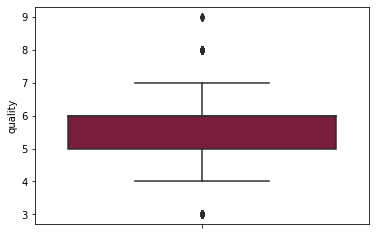

In [7]:
sns.boxplot(data = wine_raw_original, y = 'quality', color='#870e36')

<AxesSubplot:ylabel='quality'>

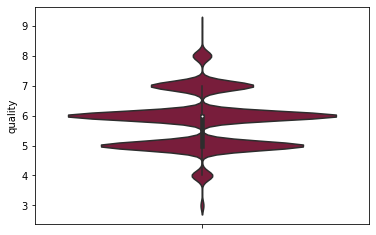

In [8]:
sns.violinplot(data = wine_raw_original, y = 'quality', color='#870e36')

In [9]:
wine_raw_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Although the description of the dataset indicates that the quality of the wine is between 0 and 10, `quality` only contains values from 3 to 9. 

Based on the graph shown, and the umbalanced quality values, the quality ranges chosen are as follows:
* 0 (Low): 3, 4, 5
* 1 (Medium): 6
* 2 (High): 7, 8, 9

In [10]:
## Option 1
# wine_raw = wine_raw_original.replace({'quality': {3: 0, 4: 0, 5: 1, 6: 1, 7: 2, 8: 2, 9: 2}})
# wine_raw['quality'].value_counts()

## Option 2 - We ended up using this one
wine_raw = wine_raw_original.replace({'quality': {3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 2, 9: 2}})
wine_raw['quality'].value_counts()

## Option 3
# wine_raw = wine_raw_original.replace({'quality': {3: 0, 4: 0, 5: 1, 6: 2, 7: 3, 8: 3, 9: 3}})
# wine_raw['quality'].value_counts()

1    2836
0    2384
2    1277
Name: quality, dtype: int64

We tried several ways of distributing the quality values, and arrived to the conclusion that the `Option 2` is the best one, data is distributed more uniformly than on the other options.

<AxesSubplot:ylabel='quality'>

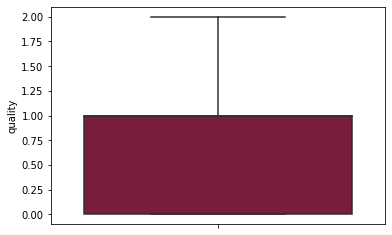

In [11]:
sns.boxplot(data = wine_raw, y = 'quality', color='#870e36')

<AxesSubplot:ylabel='quality'>

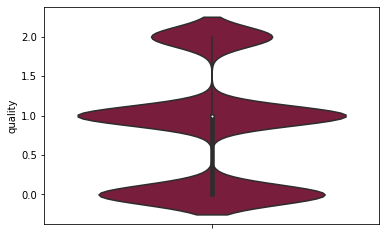

In [12]:
sns.violinplot(data = wine_raw, y = 'quality', color='#870e36')

In this way, the data is better spread over three different qualities, although the dataset itself is a bit unbalanced in this respect. It can be seen that medium quality is predominant, with high quality being the most lacking.

# 4  Data Understanding

## 4.1  First Look

In [13]:
wine_raw.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1


In [14]:
wine_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,0.829614
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.731124
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,2.000000


As mentioned, the dataset contains 13 different columns, one of which is the attribute to be predicted. At first glance, the dataset does not present any major anomalies, appart of null values. The only notable features is that the `type` column is the only one containing non-numeric values.

In [15]:
wine_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


In [16]:
wine_raw.isna().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

It can be seen that several columns contain entries with null values, which can certainly negatively affect the model to be made, and we have to treat them some way.

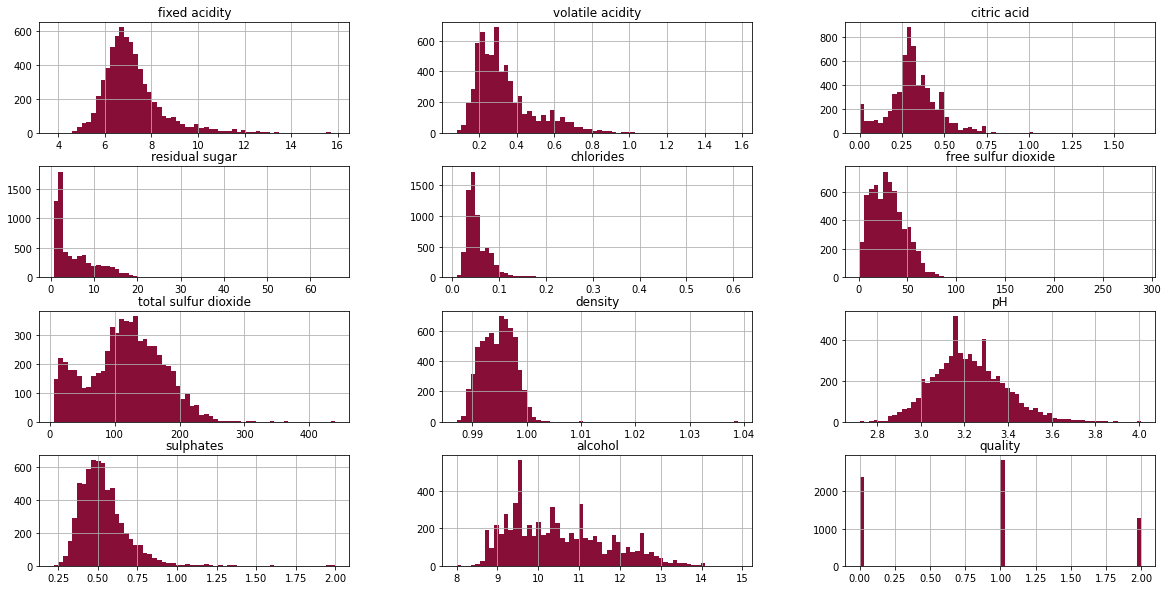

In [17]:
wine_raw.hist(bins=60, figsize=(20,10), color='#870e36')
plt.show()

Here is a first view of the graphs for each column. In general, the attributes maintain a continuous behavior, although they all have different ranges of values. They are treated one by one below to find outliers and to formulate hypotheses to better understand the correlation between the different data.

/var/folders/2k/vmp3ttk14jnf4p20cvqxtfhh0000gn/T/ipykernel_91604/2272795102.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr_mat,dtype = np.bool)


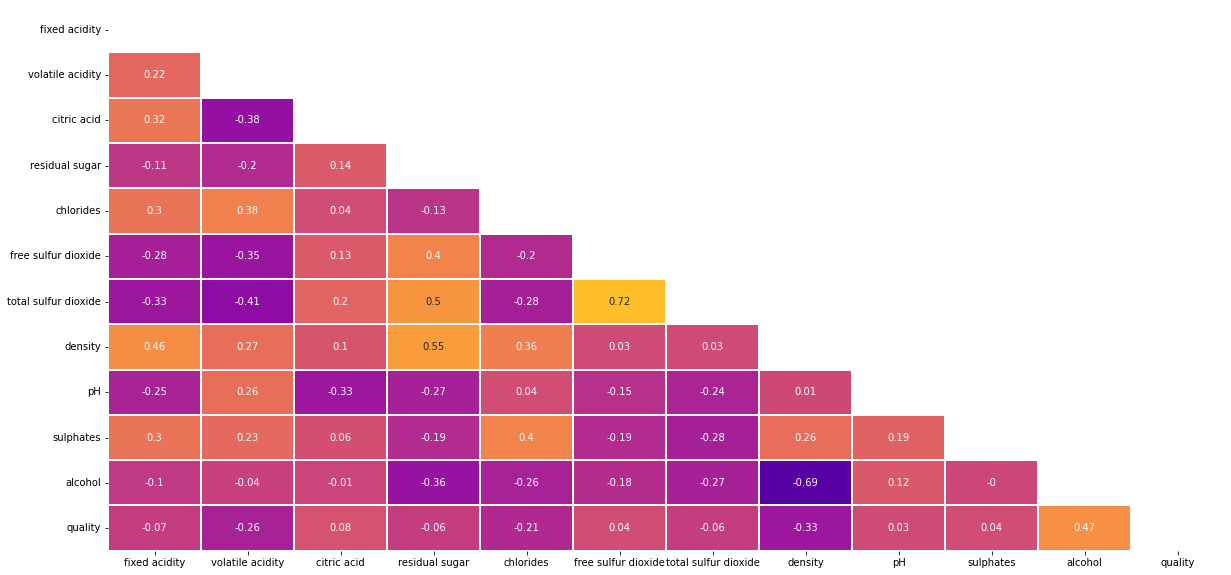

In [18]:
corr_mat = wine_raw.corr().round(2)
plt.subplots(figsize = (20,10))
mask = np.zeros_like(corr_mat,dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_mat,mask = mask,vmin = -1,vmax = 1,center = 0, cmap = 'plasma',square = False,lw = 2,annot = True,cbar = False)
plt.show() 

This figure shows the correlation of the different columns with each other. The closer the correlation is to 1 or -1, the better the linear relationship, directly or inverseley proportional. For example, it is clear that features such as `density` and `residual sugar` have a very high relationship, of 0.55 (due to the high density of sugar), so that the data dispersion between them will be smaller. The scheme can be helpful when considering different hypotheses comparing different features.

In [19]:
#sns.pairplot(wine_raw, hue="type", palette=w_r_palette)

## 4.2  Column Study

### 4.2.1  Type

There are two types of wine in the dataset: `white` and `red`. The difference when making red wine or white wine lies in the grapes, it depends on the variety of grape you use and if you let it macerate with the skin or not (grape skin) when fermenting. Red wines are made with the skin of the grape, but in the case of white wines, this part of the grape is dispensed with. This is how red wines achieve their characteristic color, thanks to the skin of the grapes, which is where the tannins are found. Other factors such as the method of maturation of the wine also have an impact.

white    4898
red      1599
Name: type, dtype: int64

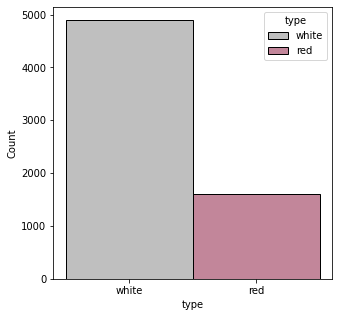

In [20]:
plt.figure(figsize=(5,5))
sns.histplot(data = wine_raw, x = 'type', hue = 'type', palette = g_r_palette)
wine_raw['type'].value_counts()

Based on the type of wine, the amount of data is moderately unbalanced. Specifically, 75% of the wines are white and 25% are red. Throughout the project, the study of data between both types will be differentiated since it turns out to be a very significant attribute for the rest of the columns.

/opt/homebrew/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


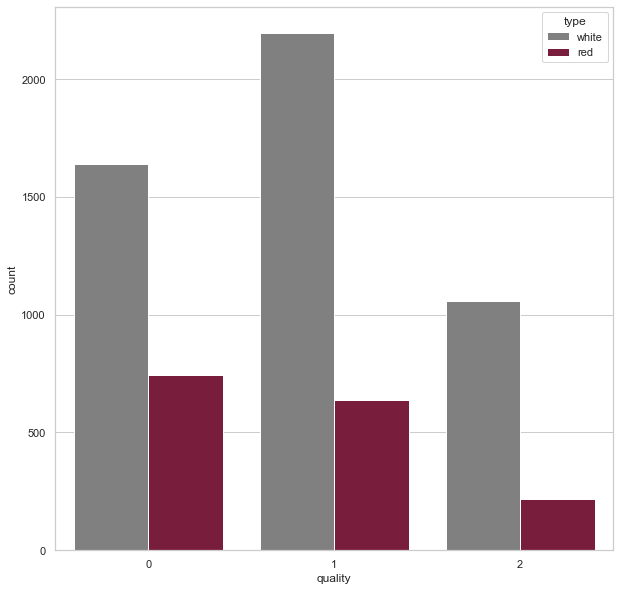

In [21]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.countplot(wine_raw["quality"], hue = "type",data = wine_raw, palette=g_r_palette)
plt.show()

Considering the lack of red wine records relative to the amount of white wine in the dataset, it seems that both types of wine follow the same pattern in terms of quality, although there is a big amount of red wine rated as low quality (0). For white wine, medium quality is undoubtedly predominant.

<AxesSubplot:xlabel='type', ylabel='quality'>

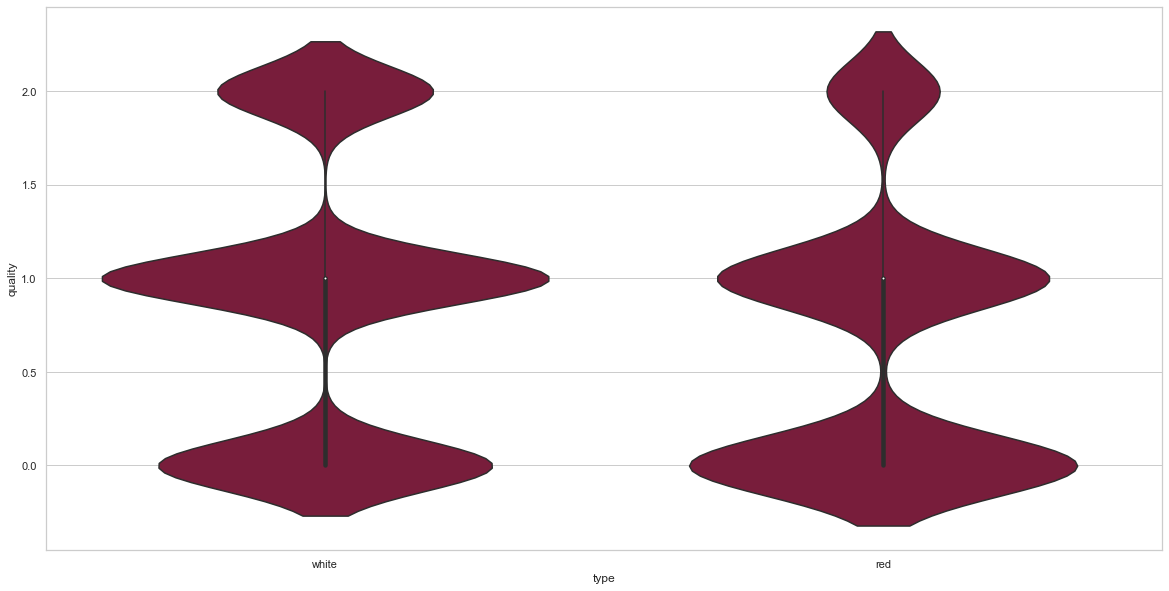

In [22]:
fig = plt.figure(figsize = (20,10))
sns.violinplot(x = "type", data = wine_raw, y = 'quality', color='#870e36')

### 4.2.2  Fixed Acidity

The predominant fixed acids found in wines are tartaric, malic, citric, and succinic. Those acids do not evaporate readily and can be measured. This attribute is expressed in $\frac{g(tartaricacid)}{l}$  in the dataset. 

Mean:  7.2165793124710955


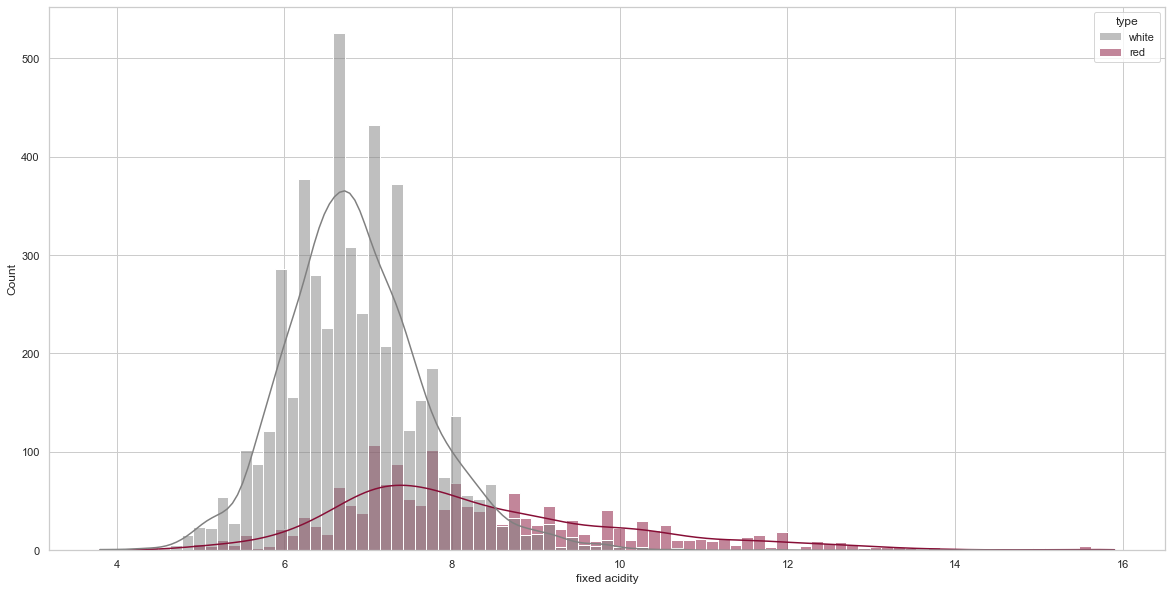

In [23]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "fixed acidity", hue = "type", palette=g_r_palette, kde = True)
print("Mean: ", wine_raw['fixed acidity'].mean())

As it can be seen in the graph below, the value of fixed acidity tends to be higher for red wine, while for white wine it is usually maintained (or slightly reduced) at an average value of 7 approx. It presents several outliers, although the behavior forms a correct Gauss curve (given the box plot).

<AxesSubplot:xlabel='type', ylabel='sulphates'>

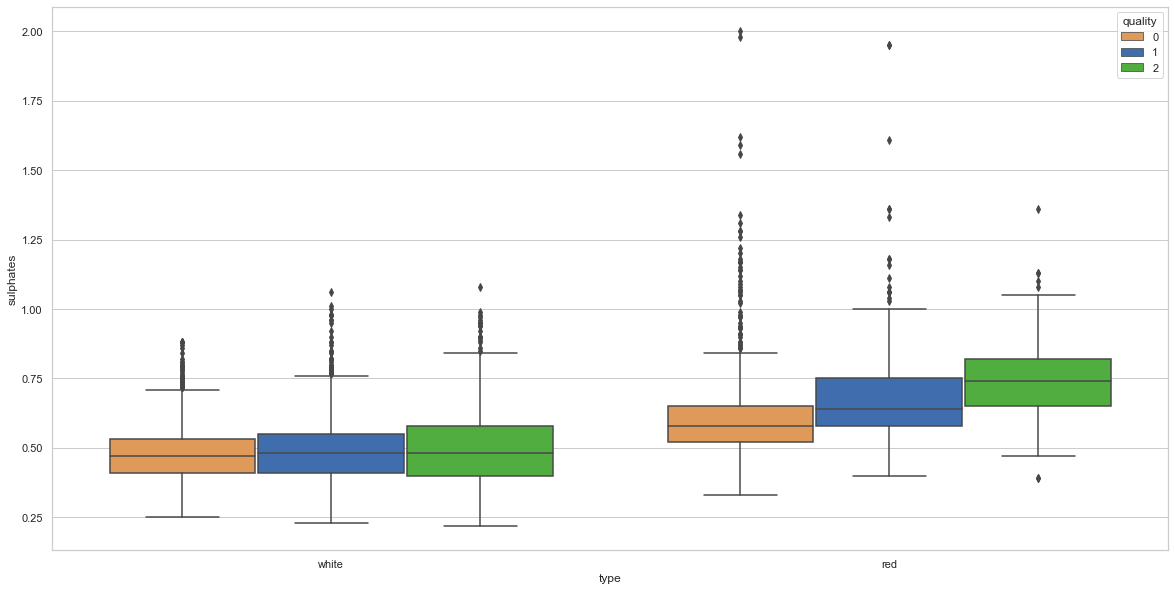

In [24]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'sulphates', hue="quality", palette=quality_colors, data = wine_raw)

We can confirm that the fixed acidity for the white wines is generally lower and less disperse than the red wine. For the red wine it seems that the fixed acidity and the quality are directly proportional, with higher acidity resulting in a higher quality red wine.

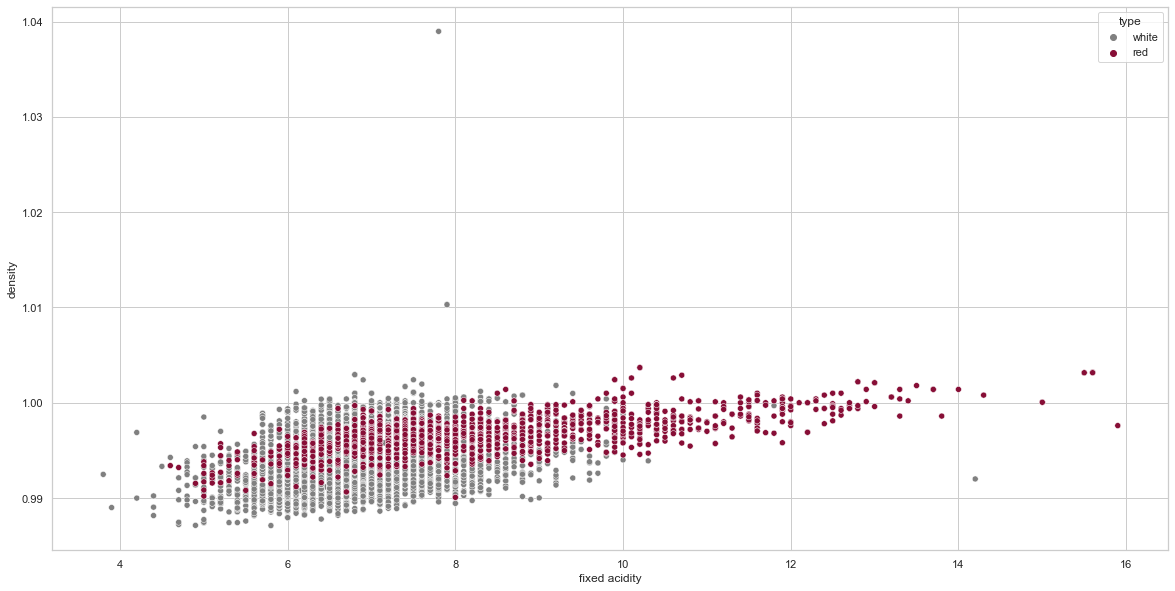

In [25]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='fixed acidity', y='density', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 46%** <br>
It can also be seen that `fixed acidity` correlates well with `density`. This is confirmed by the linear trend of the points from left to right in an ascending direction. It should be noted that there are some outliers that dont represent the usual behavior.

### 4.2.3  Volatile Acidity

It refers to the acidic elements of a wine that are gaseous, rather than liquid, and therefore can be sensed as a smell. The amount of VA in wine is often considered an indicator of spoilage (deterioration). That's why when wine ages, its volatile acidity increases and it tastes more like vinegar. This attribute is expressed in $\frac{g(acetic acid)}{l}$ in the dataset.

Mean:  0.33969101556480197


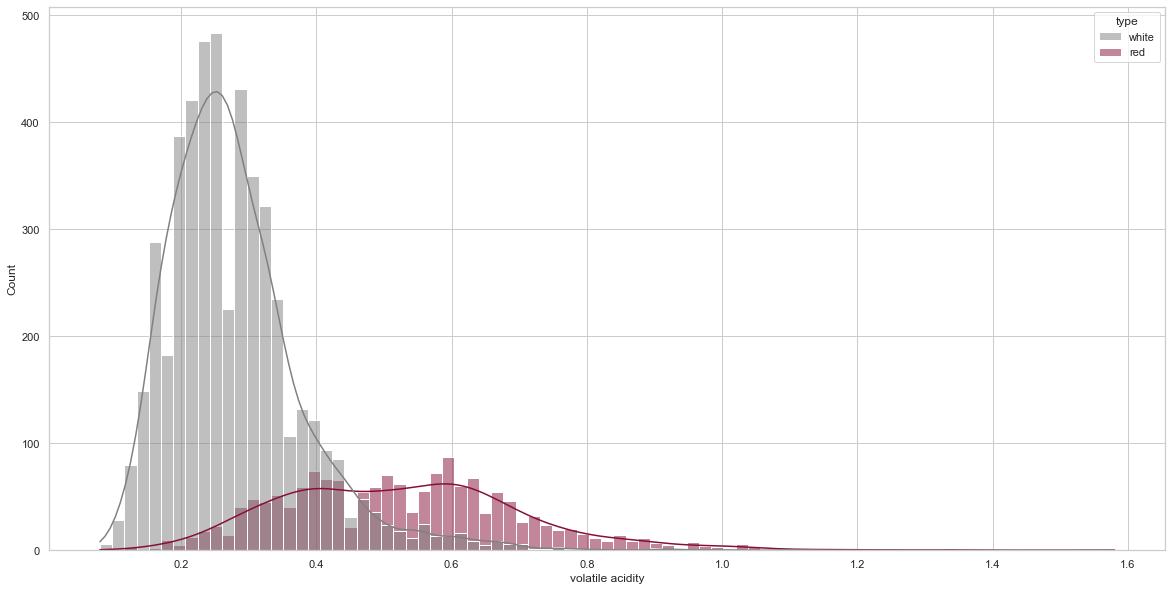

In [26]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "volatile acidity", hue = "type", palette=g_r_palette, kde = True)
print("Mean: ", wine_raw['volatile acidity'].mean())

The maximum volatile acidity, calculated as acetic acid and exclusive of sulfur dioxide, is 0.14 g/100 mL for red wine and 0.12 g/100 mL for white wines. As it occurs with fixed acidity, the value of volatile acidity obtains a higher value in red wine and in white wine it is more concentrated (less deviation from the median). In both cases the behavior of the data is continuous except for some specific value. 

<AxesSubplot:xlabel='type', ylabel='volatile acidity'>

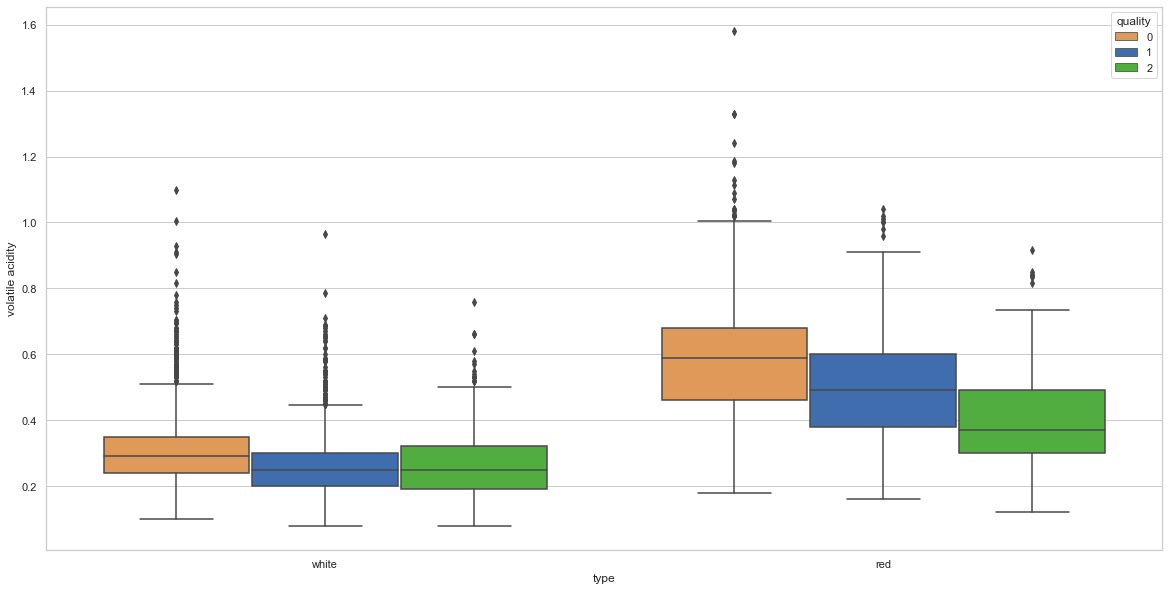

In [27]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'type', y = 'volatile acidity', hue="quality", palette=quality_colors, data = wine_raw)

Several outliers appear exceeding the average value, especially in low quality red wines. In the three possible qualities, red wine outperforms white, the latter having a more concentrated behavior (less deviation from the median) due to the large amount of data.

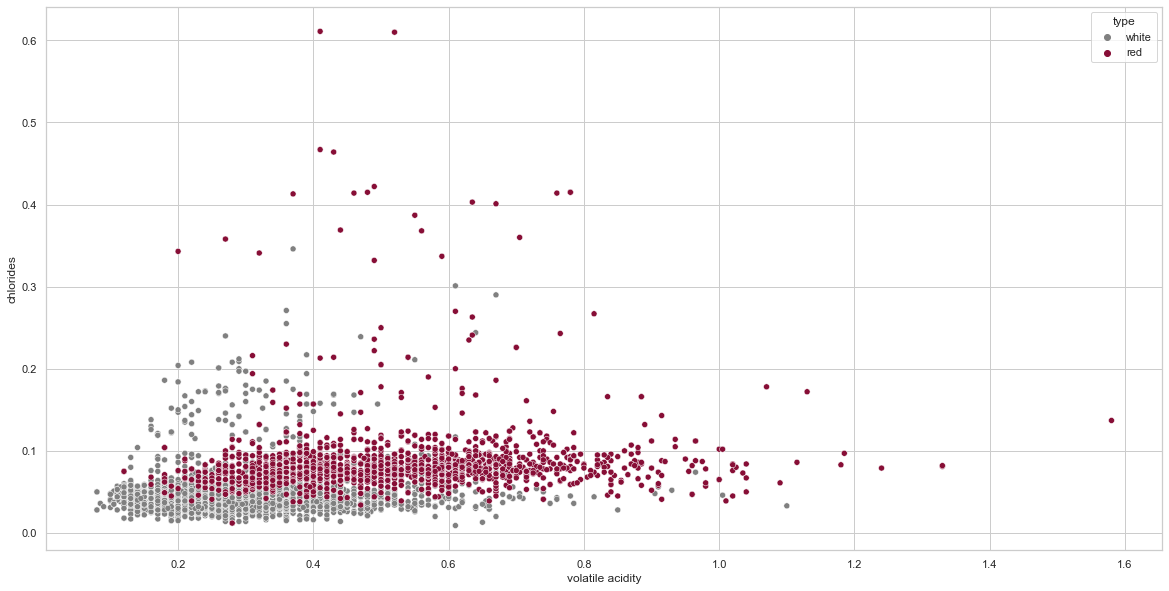

In [28]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='volatile acidity', y='chlorides', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 38%** <br>
Despite the fact that `chlorides` is the attribute with which it maintains the best correlation, there is still a great dispersion of data and showing multiple outliers. Even so, the general behavior is linear and the relationship between both columns can be appreciated as direcly proportional.

### 4.2.4  Citric Acid

Citric acid is one of the less commonly found acid’s in wine. It is most commonly used as an acid supplement during the fermentation process to help winemakers boost the acidity of their wine especially grapes grown in warmer climates. This attribute is expressed in $\frac{g}{l}$ in the dataset.

Mean:  0.3187218971358176


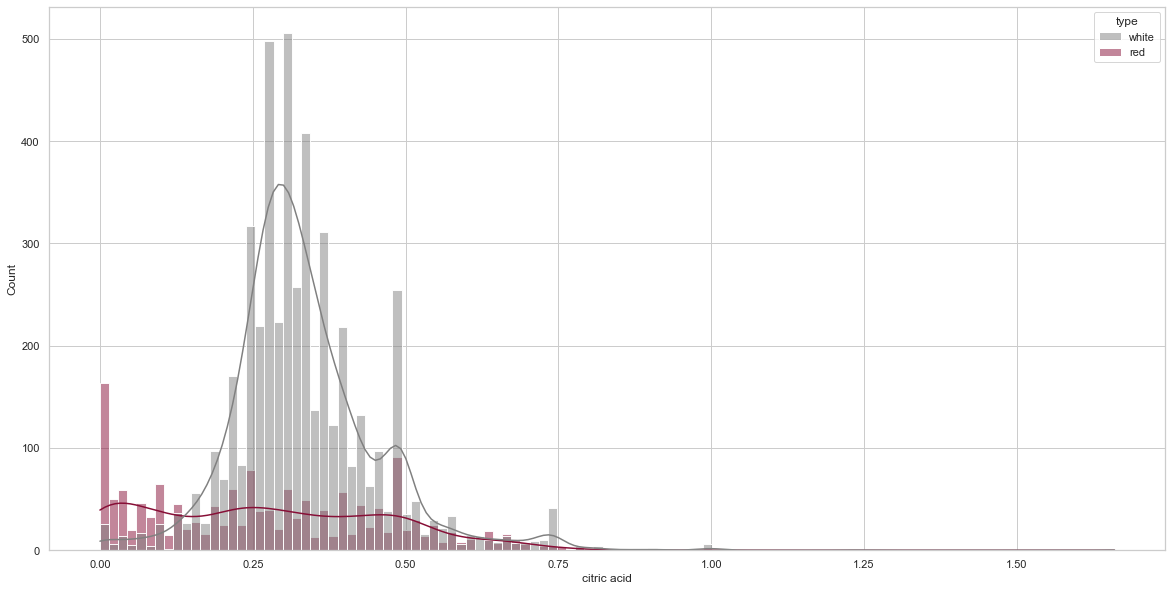

In [29]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "citric acid", hue = "type", palette=g_r_palette, kde = True)
print("Mean: ", wine_raw['citric acid'].mean())

It should be noted that there are many red-type wines that have a value of 0.0 citric acid, thus demonstrating that it is not a very common attribute. Unlike white wine, this one has a much more evident average value and there is not too much dispersion of data.

<AxesSubplot:xlabel='type', ylabel='citric acid'>

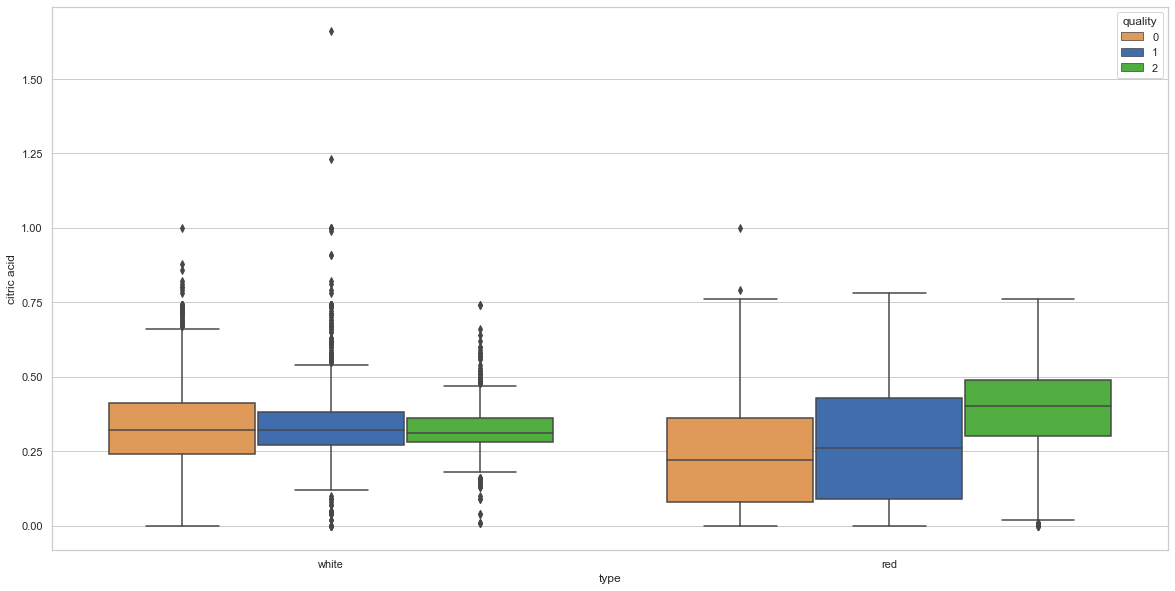

In [30]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'type', y = 'citric acid', hue="quality", palette=quality_colors, data = wine_raw)

It can be observed that only in high quality red wine slightly exceeds the median of white wine, without presenting too many outliers. In the rest of the qualities, both wines show several differences.

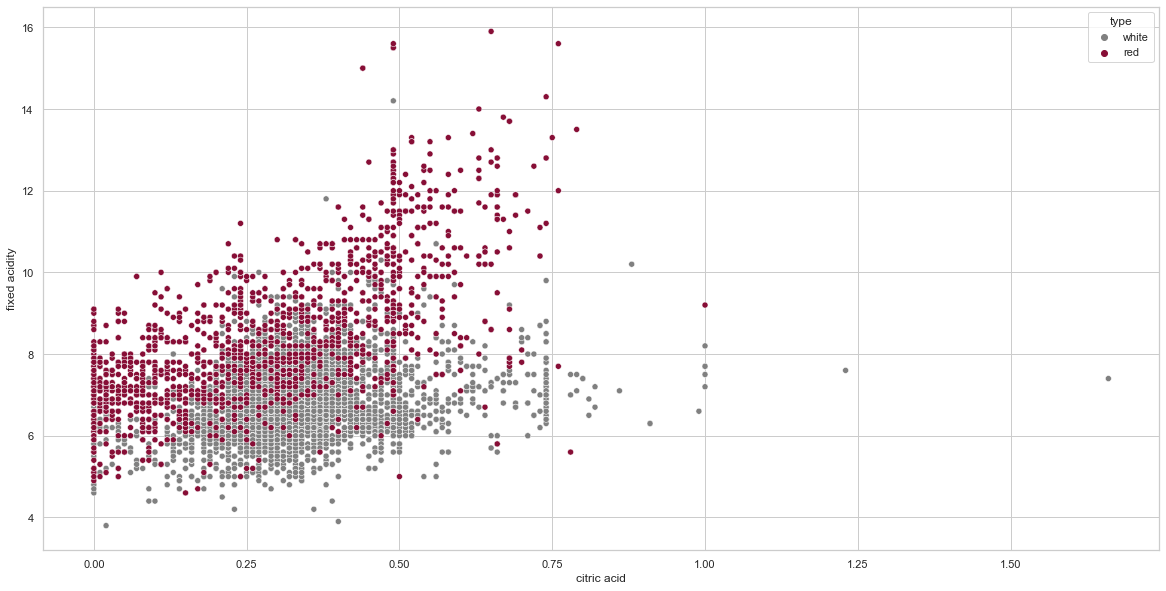

In [31]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='citric acid', y='fixed acidity', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 32%** <br>
The citric acid helps to determinate the amount of fixed acidity in the wine. Despite this, the correlation it has with `fixed acidity` is not too high, we could see from this graph that there is a wide range of values. The data remain moderately grouped, although the values of red wine tend to stand out from the common behavior.

### 4.2.5  Residual Sugar - C₁₂H₂₂O₁₁

It is from natural grape sugars leftover in a wine after the alcoholic fermentation finishes, the amount of residual sugar affects a wine’s sweetness. This attribute is expressed in $\frac{g}{l}$ in the dataset.

Mean:  5.444326404926867


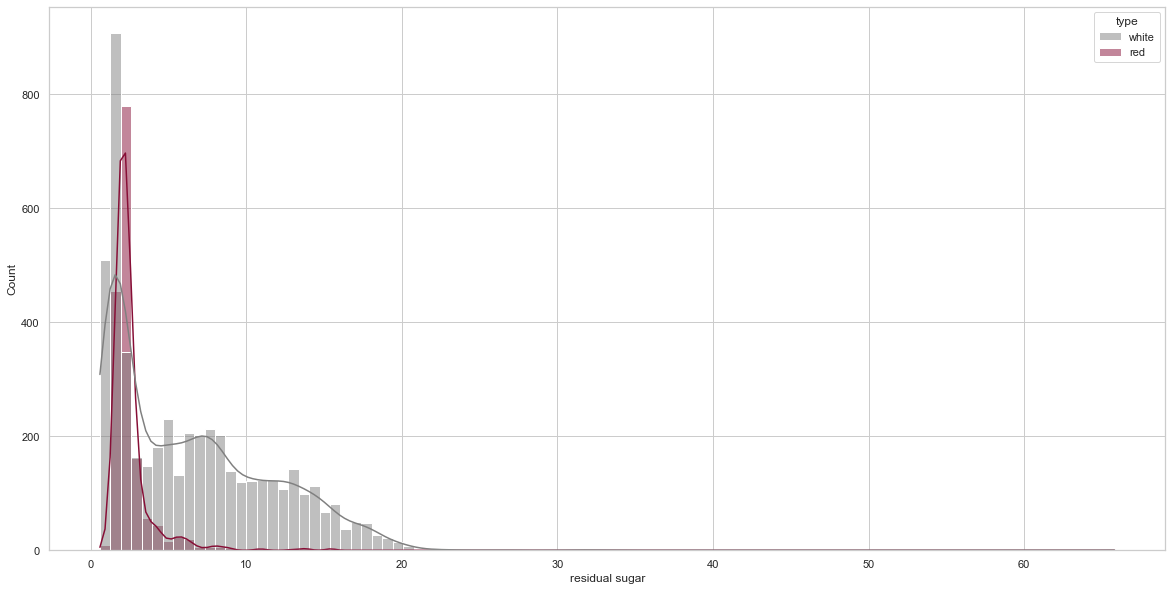

In [32]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "residual sugar", hue = "type", palette=g_r_palette, kde = True)
print("Mean: ", wine_raw['residual sugar'].mean())

Surprisingly, both types of wine agree that the residual sugar tends to be relatively low, obtaining many records with an amount of sugar close to zero. Even so, there are several wines that have a higher residual sugar (mainly white wine). We assume that red wine follows a similar trend to white wine even though less data is present.

<AxesSubplot:xlabel='type', ylabel='residual sugar'>

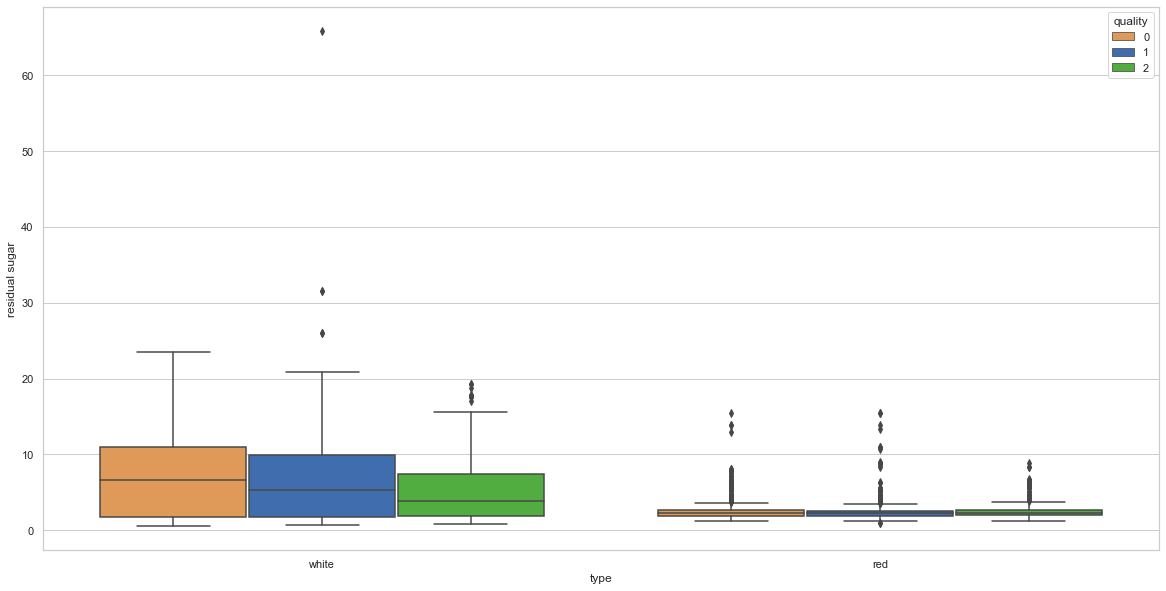

In [33]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'type', y = 'residual sugar', hue="quality", palette=quality_colors, data = wine_raw)

The minimum values are similar between both types of wine, while white wine reaches higher values. On the other hand, medium-quality white wine presents a very prominent outlier that we can probably eliminate to improve the results of the model.

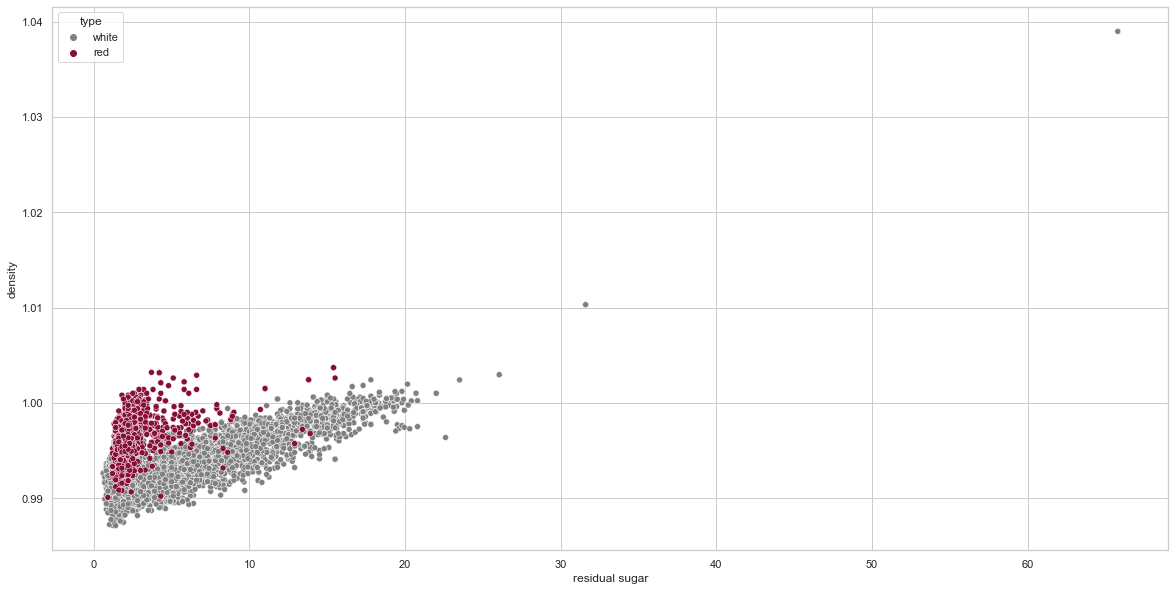

In [34]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='residual sugar', y='density', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 55%** <br>
This component maintains a good relationship with the `density` column. In fact, as freshly harvested grapes are composed of around 25% sugar, sugar is the dominant component of the density. Therefore, it is a normal state that both features present a linear behavior.

### 4.2.6  Chlorides - Cl

The level of Chloride and sodium ions in wines essentially depends on the
geographic, geologic and climatic conditions of grapevine cultivation. This attribute is expressed in $\frac{g(sodiumchloride)}{l}$ in the dataset.

Mean:  0.05604157043879908


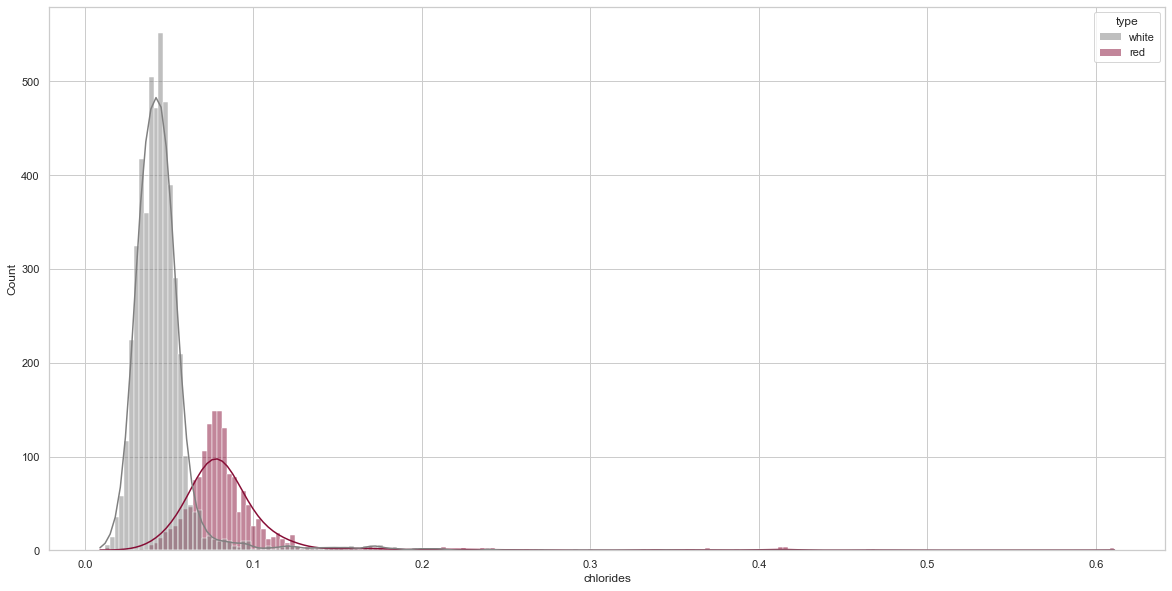

In [35]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "chlorides", hue = "type", palette=g_r_palette, kde = True)
print("Mean: ", wine_raw['chlorides'].mean())

Ignoring the difference in the amount of each type, red wine has a higher amount of chlorides than white wine. In both cases the data continuity is very good and the behavior is adequate. Research suggests that chloride concentration in juice is a good predictor of the final concentration in a white wine; however, juice chloride concentration should be multiplied by 1.7 to estimate concentration in red wine. The higher extraction of chloride during red winemaking is due to the ions extracted from skins during fermentation

<AxesSubplot:xlabel='type', ylabel='chlorides'>

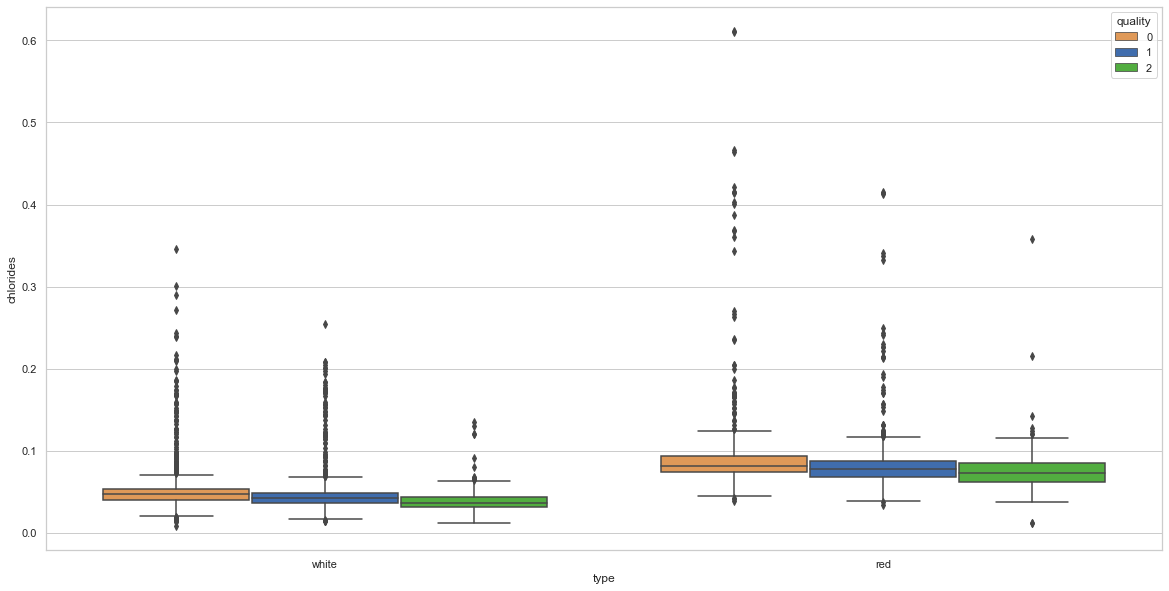

In [36]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'type', y = 'chlorides', hue="quality", palette=quality_colors, data = wine_raw)

Regarding quality, similar data are maintained in all cases and certain outliers stand out that can be discarded.

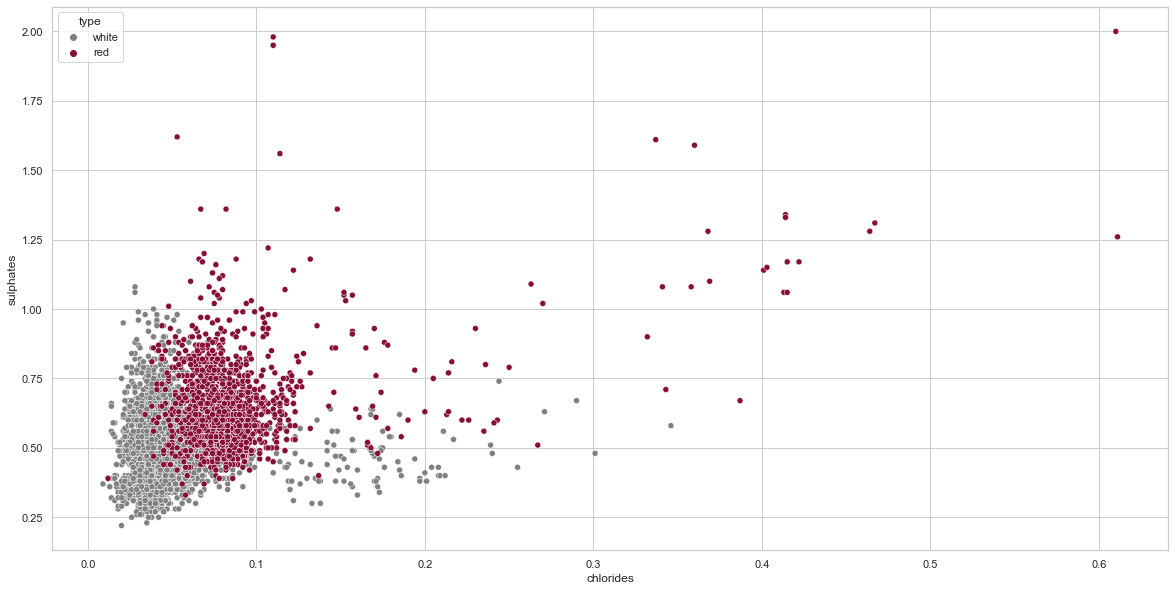

In [37]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='chlorides', y='sulphates', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 40%** <br>
Although there is some scatter, the chlorides comprise a good correlation with the column `sulphates`. The concentrations of these anions in must and wine vary according to the winemaking method and storage vessels and other factors.

### 4.2.7  Free Sulfur Dioxide  - SO₂

It is the portion of sulfur dioxide that hasn't reacted to other chemicals in the wine such as aldehydes, pigments, or sugars. When it is added to a wine is said to be free after the remaining part binds to other components in the wine. This attribute is expressed in $\frac{mg}{l}$ in the dataset.

Mean:  30.525319378174544


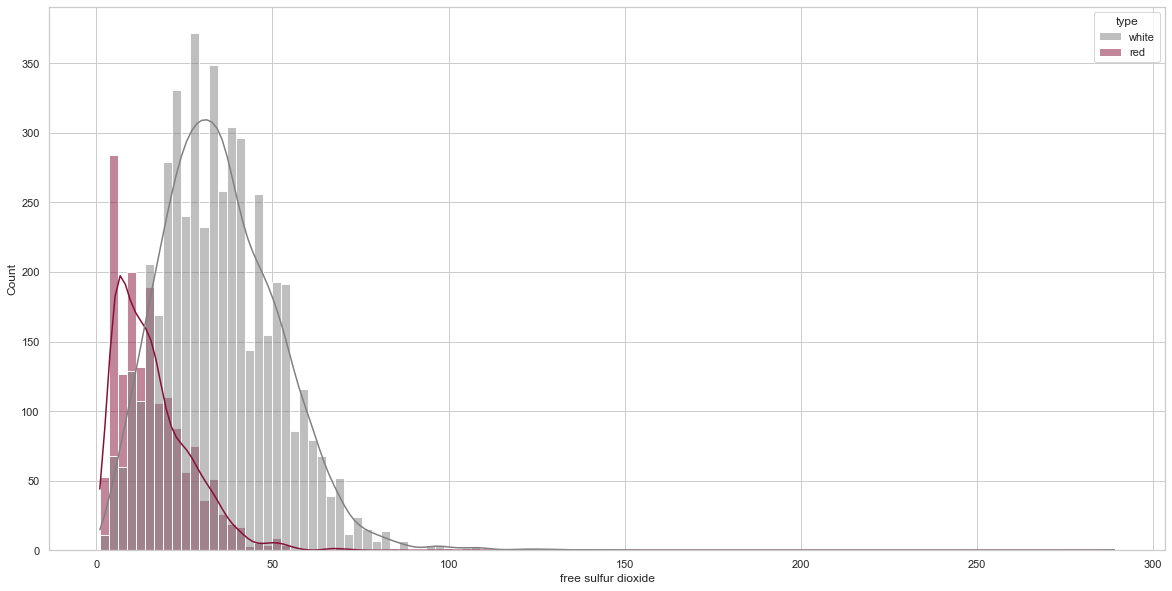

In [38]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "free sulfur dioxide", hue = "type", kde = True, palette = g_r_palette)
print("Mean: ", wine_raw['free sulfur dioxide'].mean())

As can be seen, red wine is the one with the least amount of free sulfur dioxide, reaching a value close to 0 on several occasions. In fact, it is considered normal for red wine to have a very low amount of this chemical compound.

<AxesSubplot:xlabel='type', ylabel='free sulfur dioxide'>

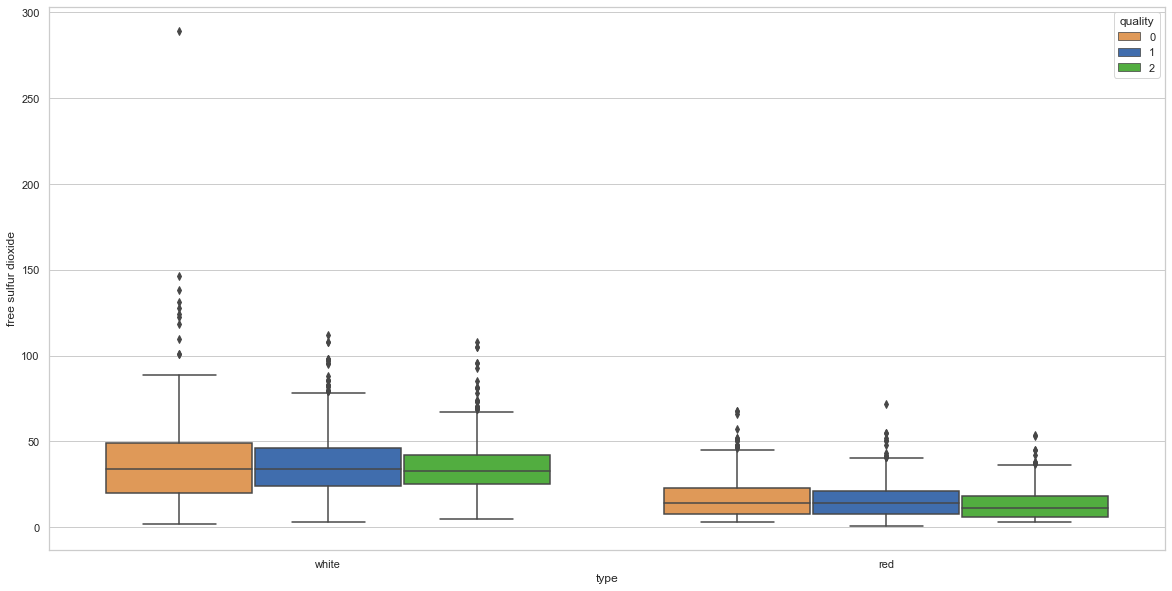

In [39]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'type', y = 'free sulfur dioxide', hue="quality", palette=quality_colors, data = wine_raw)

It can be seen that the amount of free sulfur dioxide decreases slightly the higher the quality of the wine, as well as the total sulfur dioxide. Despite this, the data is quite consistent and the difference between types of wine is maintained in all cases.

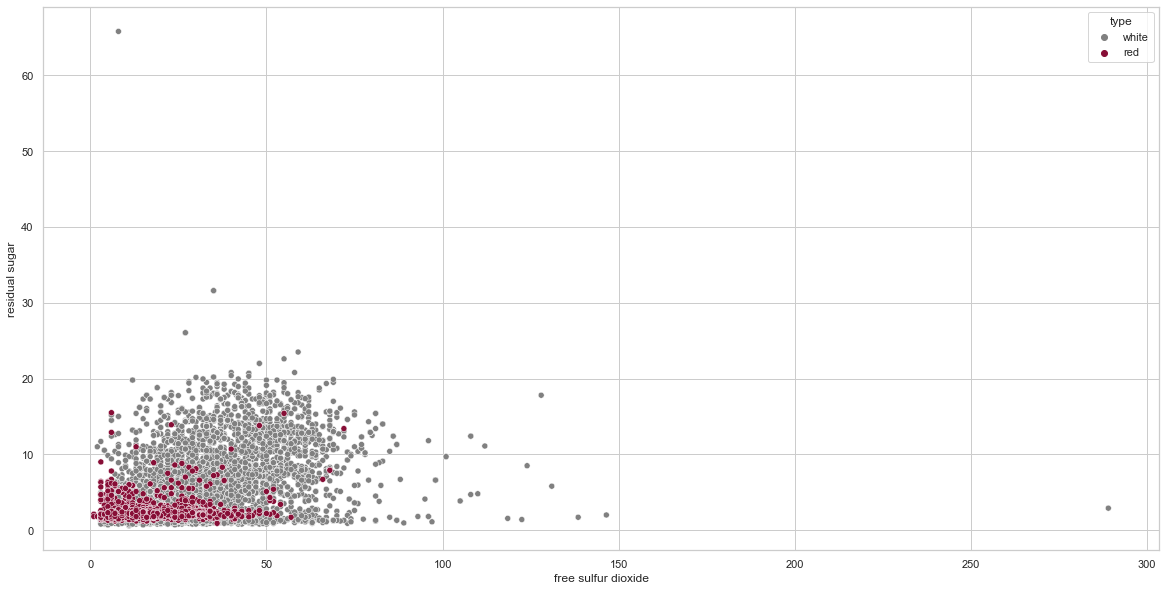

In [40]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='free sulfur dioxide', y='residual sugar', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 40%** <br>
This compound contains certain binders such as glucose, which is a type of sugar that adds sweetness to the flavor of the wine. That is why residual sugar is so closely related to sulfur dioxide.

### 4.2.8  Total Sulfur Dioxide  - SO₂

This value is the total amout of free sulfur dioxide added to the wine. This substance is added to kill the bacteria and to preseverve the quality of the wine. This attribute is expressed in $\frac{mg}{l}$ in the dataset.

Mean:  115.7445744189626


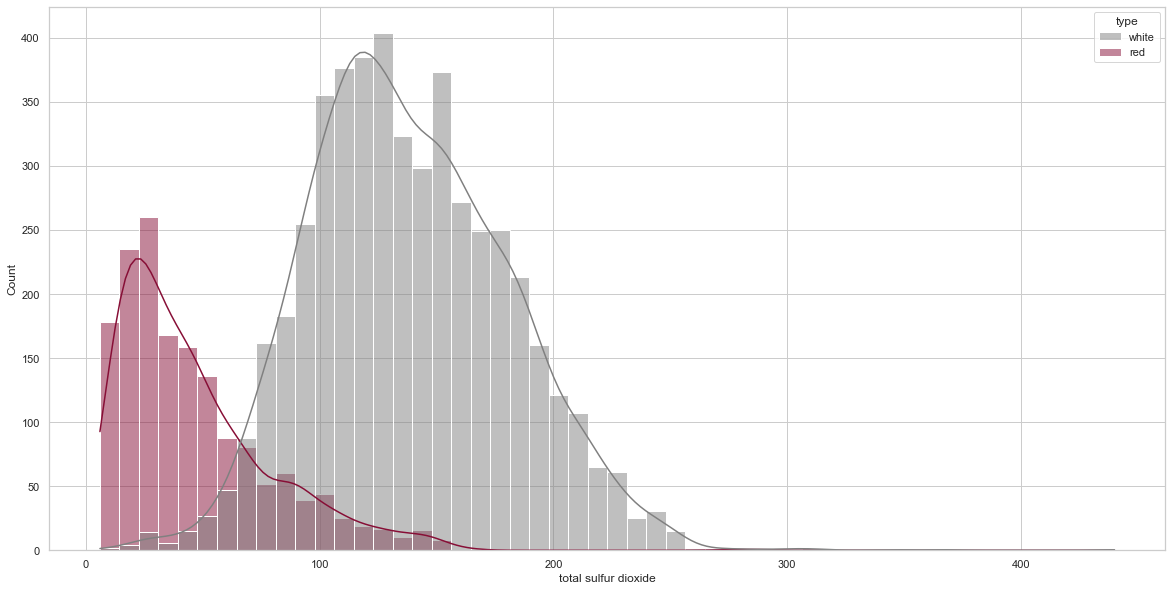

In [41]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "total sulfur dioxide", hue = "type", kde = True, palette=g_r_palette)
print("Mean: ", wine_raw['total sulfur dioxide'].mean())

The behavior is similar to the previous case, taking into account that we are talking about the same component but, in this case, we are talking about all the sulfur dioxide added to the wine (regardless of whether it has reacted or not with other components).

<AxesSubplot:xlabel='type', ylabel='total sulfur dioxide'>

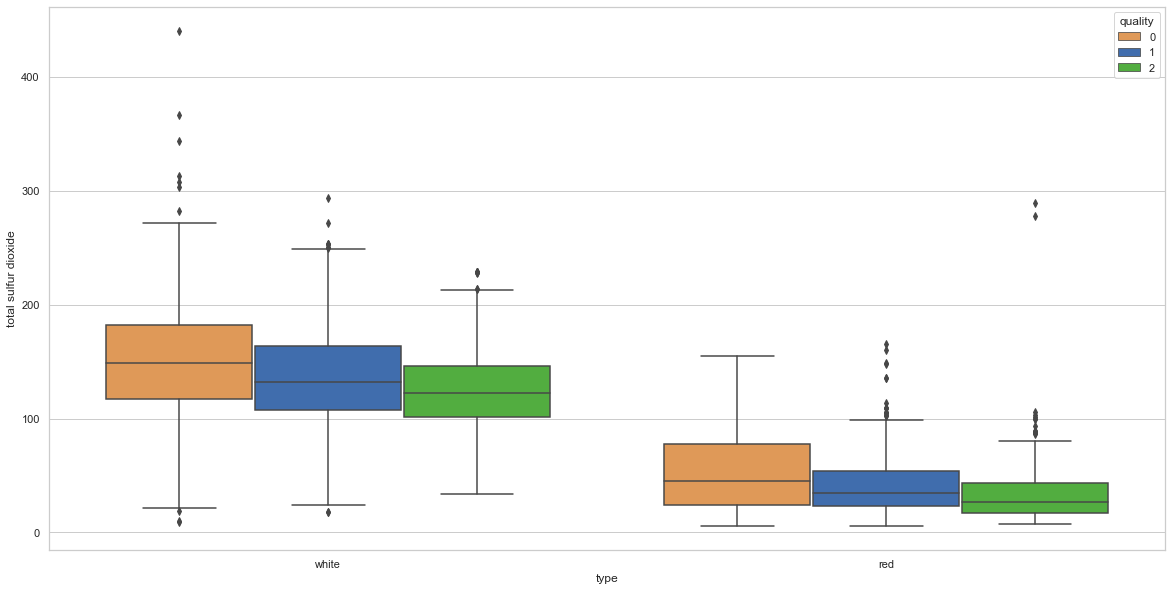

In [42]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'total sulfur dioxide', hue="quality", palette=quality_colors, data = wine_raw)

In all types of quality, the distribution of total sulfur dioxide is similar, the average, maximum and minimum badness of the different types is maintained and certain outliers can be seen in the lower qualities.

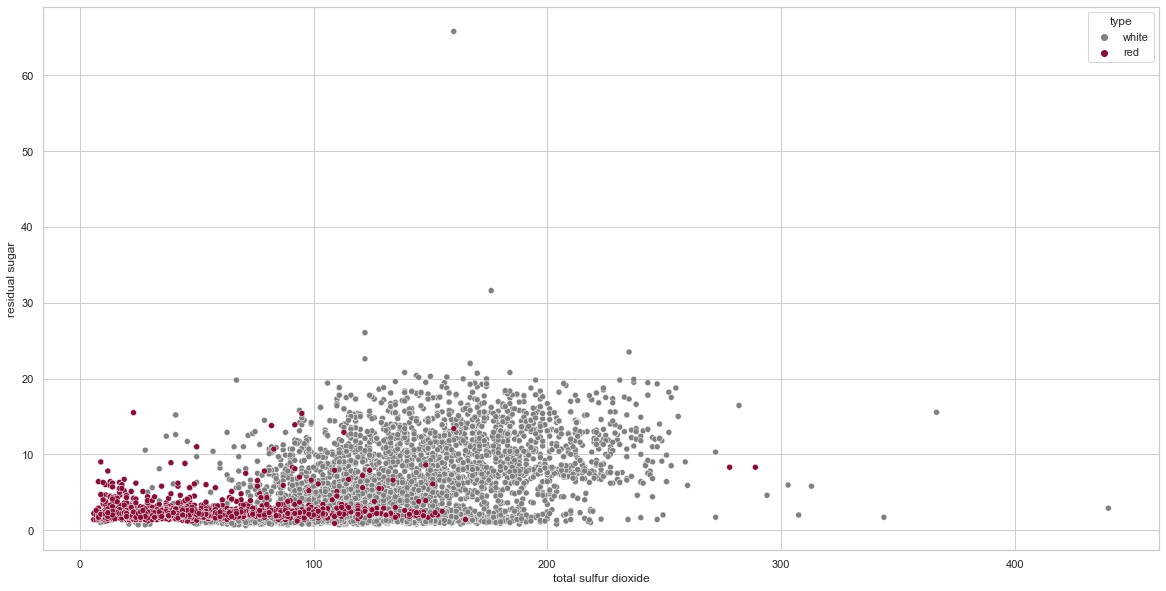

In [43]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='total sulfur dioxide', y='residual sugar', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 50%** <br>
As we have previously mentioned, this compound is related to the residual sugar in wine.

### 4.2.9  Density

This is the relation beetwen the weight of a specific wine and it's volume, it is dependent of the components of the wine. For example, if it has more alcohol (being that the density of alcohol is lower than the one of the wine) it affects the density of the wine, lowering it. This attribute is expressed in $\frac{g}{ml}$ in the dataset.

Mean:  0.9946966338309989


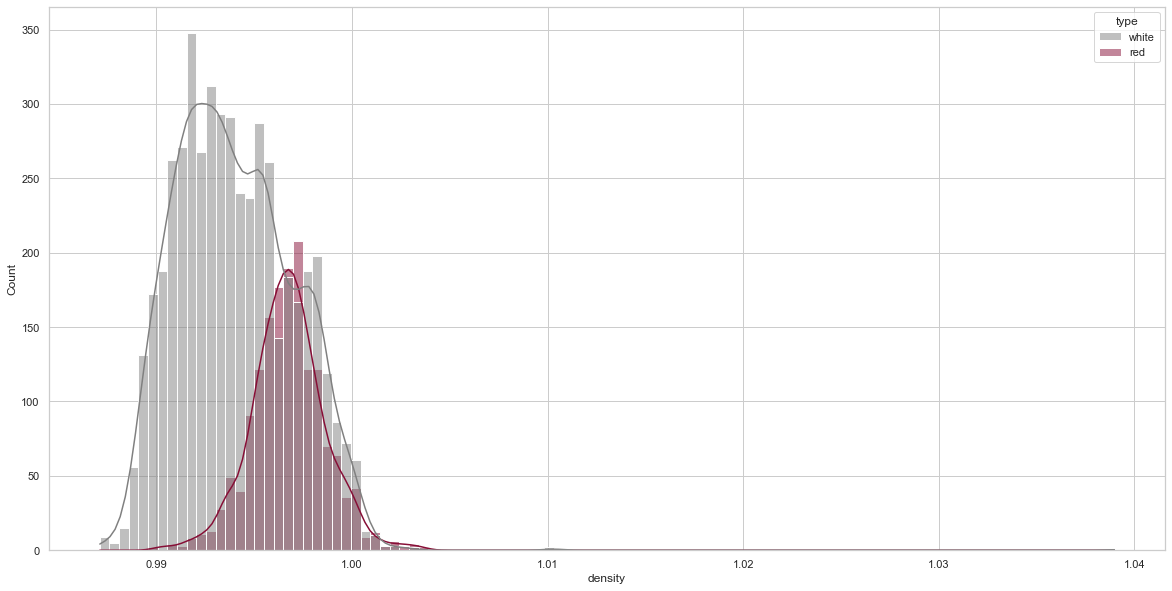

In [44]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "density", hue = "type", kde = True, palette=g_r_palette)
print("Mean: ", wine_raw['density'].mean())


As you can see, red wine tends to have more density than white wine, among other things because it contains more chlorides, which, being denser, increase the density of the wine.

<AxesSubplot:xlabel='type', ylabel='density'>

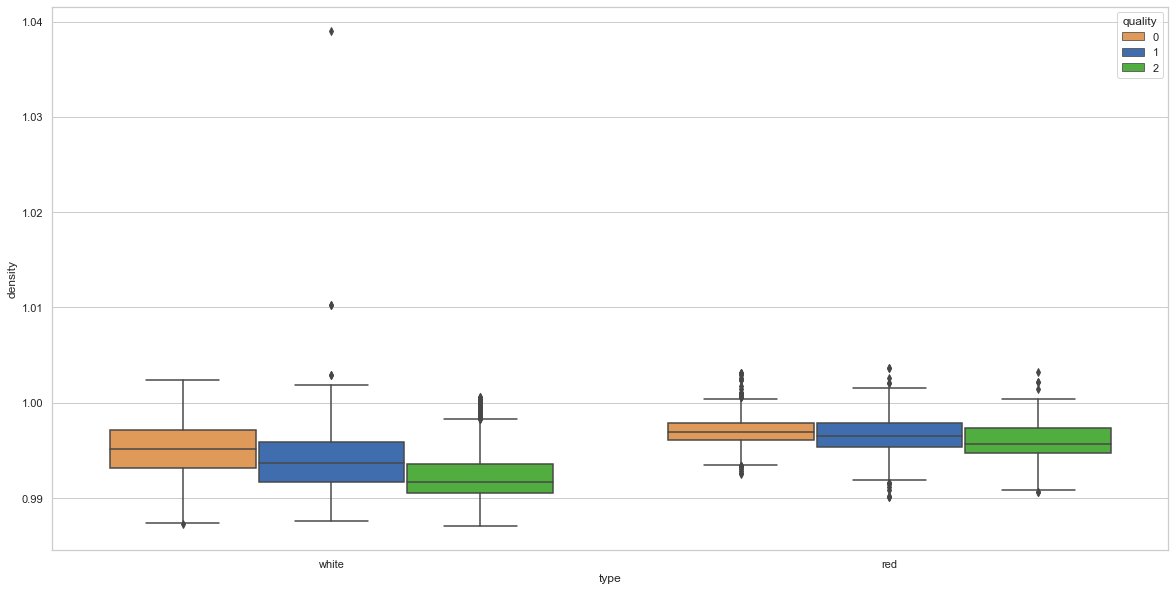

In [45]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'density', hue="quality", palette=quality_colors, data = wine_raw)

Due to the density being dependent of multiple attributes of the dataset, it hasn't a direct correlation with the wine quality. For example, the chorides have a density of more than 2 g/ml. An outlier is also detected in the medium quality.

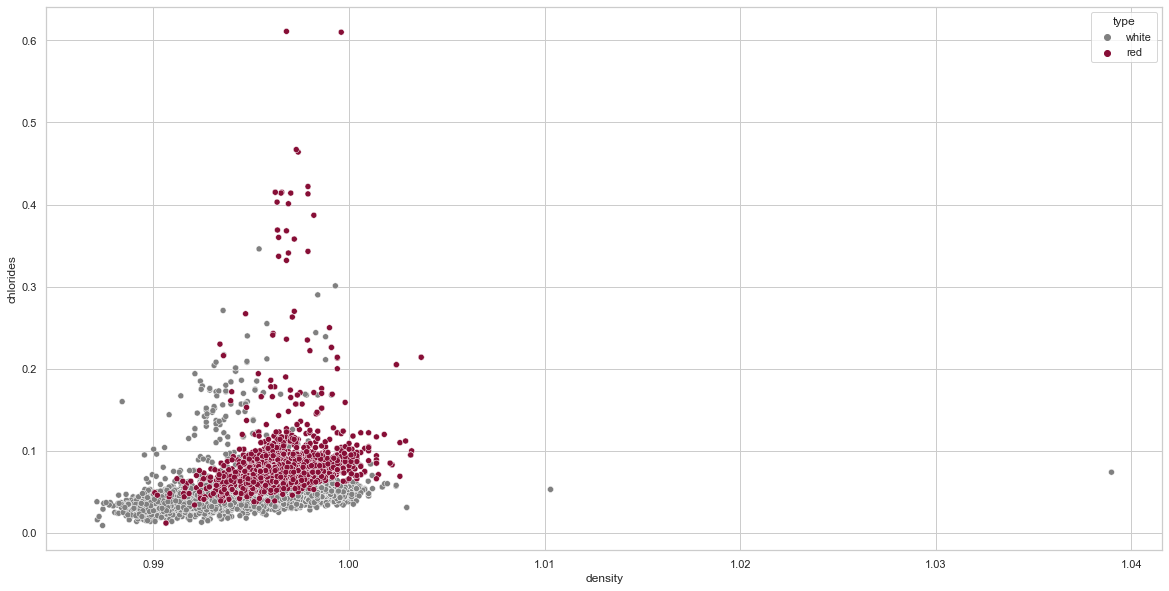

In [46]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='density', y='chlorides', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 36%** <br>
Here we can verify that substances such as chloride are more present in red wine than in white, confirming that it affects the density of the wine. The ratio of both columns is moderately high and the behavior is slightly linear.

### 4.2.10  pH

It is the unit of measure of the acidity or alkalinity that we can find in the wine. This unit of measurement is distributed along a scale that goes from 0 to 14, taking 7 as neutral, with the values closest to 0 indicating that the solution is more acidic and the values closest to 14 those that indicate that this solution is more alkaline or basic, as it is also called.

Mean:  3.218395499383477


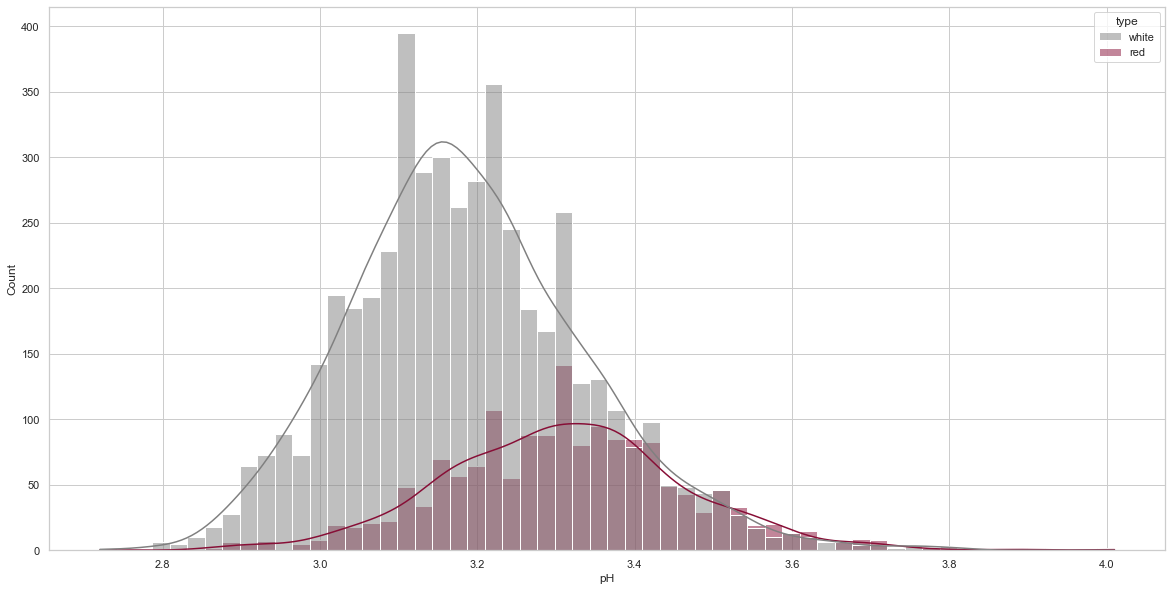

In [47]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "pH", hue = "type", kde = True, palette=g_r_palette)
print("Mean: ", wine_raw['pH'].mean())

White wines usually have a pH between 3 and 3.3 while most reds tend to be between 3.3 and 3.6. This confirms that the acidity of the wine also depends on the pH, both types have a medium-high acidity.

<AxesSubplot:xlabel='type', ylabel='pH'>

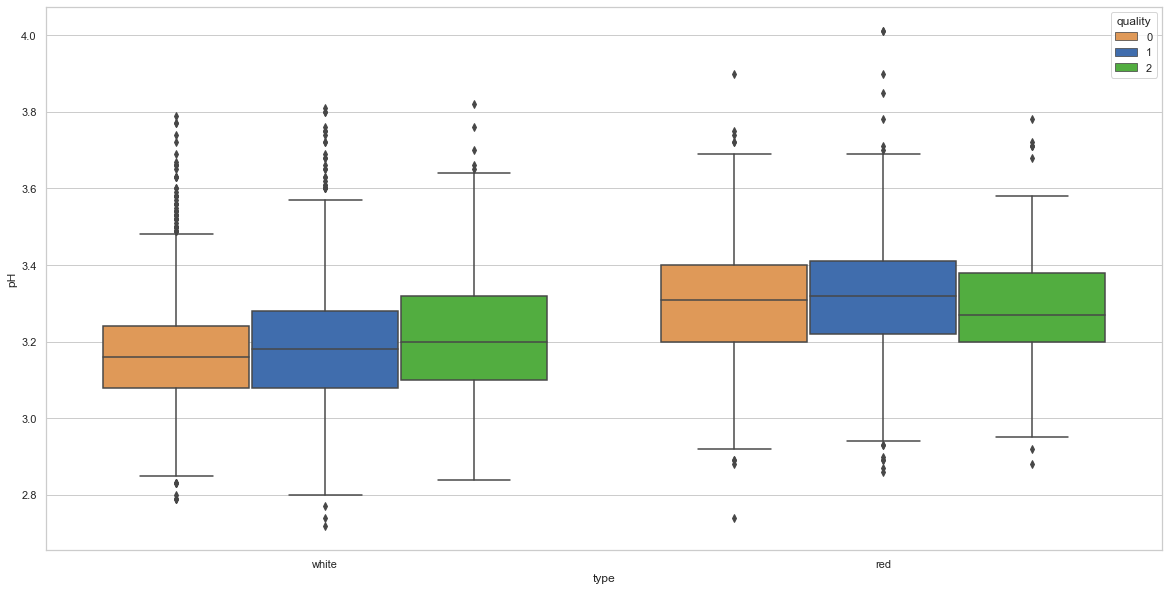

In [48]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'pH', hue="quality", palette=quality_colors, data = wine_raw)

When a wine has a suitable acidic pH, many of its properties improve, in addition to allowing the wine to be a healthy product without any problem of bacteria and viruses. In this case, the pH is similar in all types of quality and the median is normal, both for red wine and white wine.

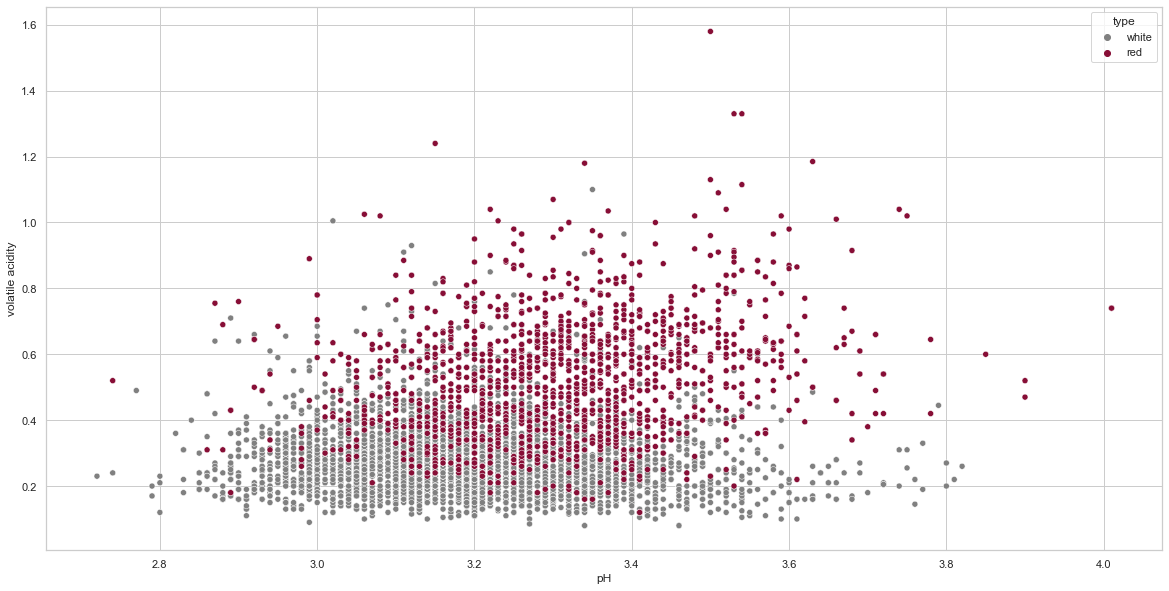

In [49]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='pH', y='volatile acidity', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 26%** <br>
The pH depends on the concentration of the different acids in the wine, but these acids change in concentration depending on the grape varieties, the climate, the different fermentations, and even the production methods. The different acids have different "power" of acidity, so the most powerful is malic and the weakest is lactic, the most important in grapes being tartaric.
But if we have a lot of tartrates in the wine, surely the pH will be higher.

### 4.2.11  Sulphates

The sulphates are the number of minerals with sulphate on the wine. This characteristic, is related to the fermentation process of the wine and it is considered a key component for it's elaboration. This attribute is expressed in $\frac{g(potassiumsulphate)}{l}$ in the dataset.

Mean:  0.531215154782073


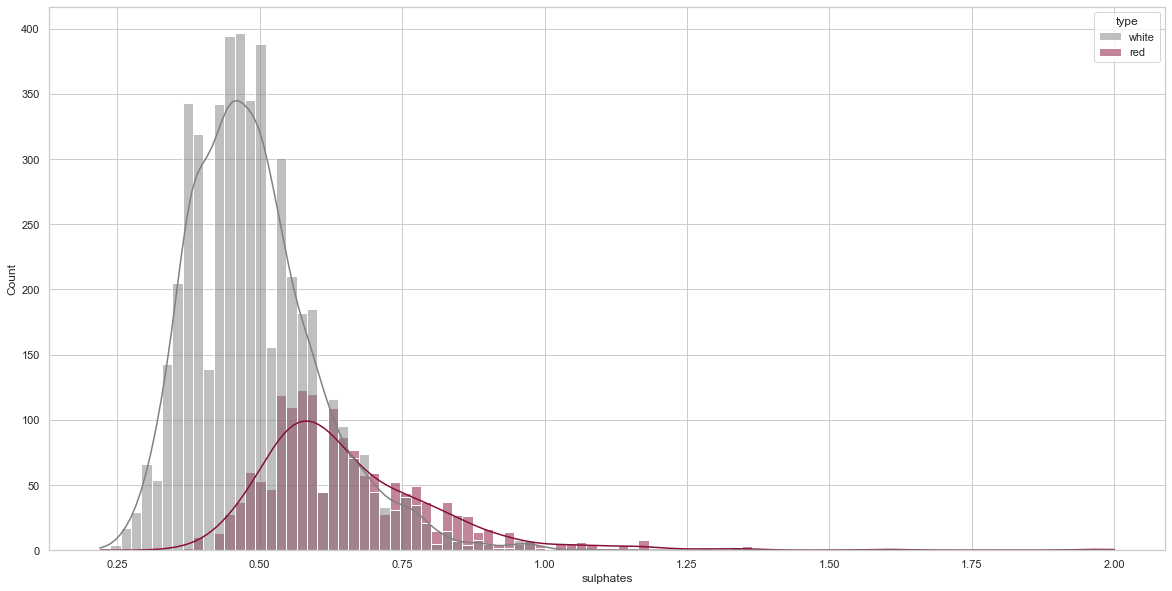

In [50]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "sulphates", hue = "type", kde = True, palette=g_r_palette)
print("Mean: ", wine_raw['sulphates'].mean())

White wines are generally sweeter than red wines. In addition, the skin of the grape in contact with the must gives it prolonged effects, which also explains why red wines require a higher dose of sulphites.

<AxesSubplot:xlabel='type', ylabel='sulphates'>

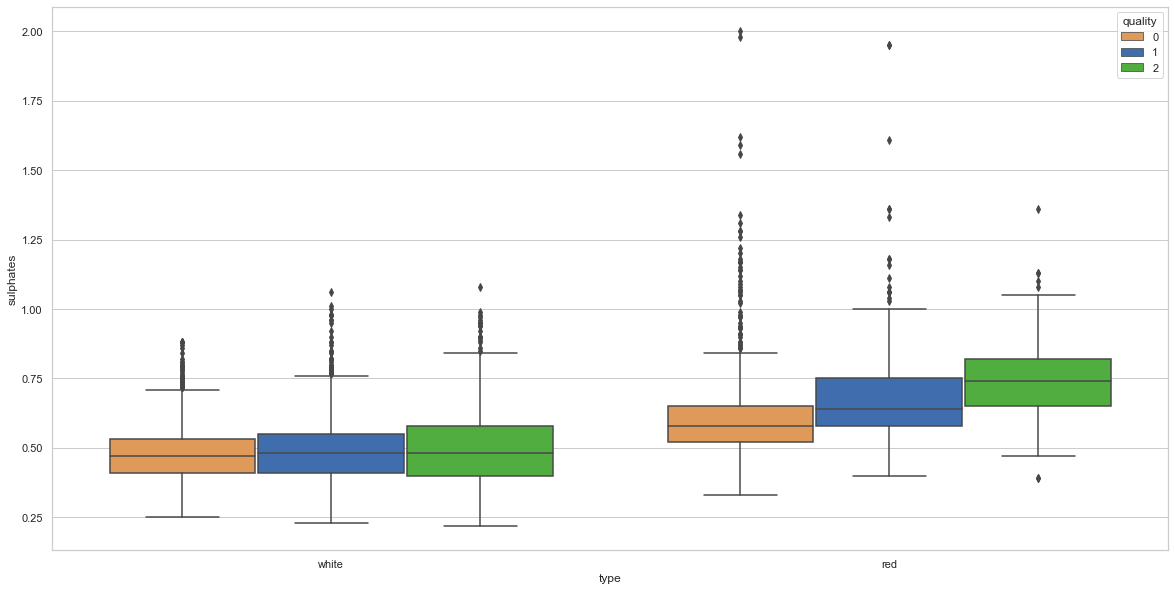

In [51]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'sulphates', hue="quality", palette=quality_colors, data = wine_raw)

It can be seen that, especially in red wine, the amount of sulphites is greater in the highest quality. And it is that this component contributes to activate the alcoholic fermentation and has effects on the maceration, the color, the smell and the taste of the wine. Sulfites in wine have preservative functions, they are antioxidants, antimicrobial agents and antioxidasics.

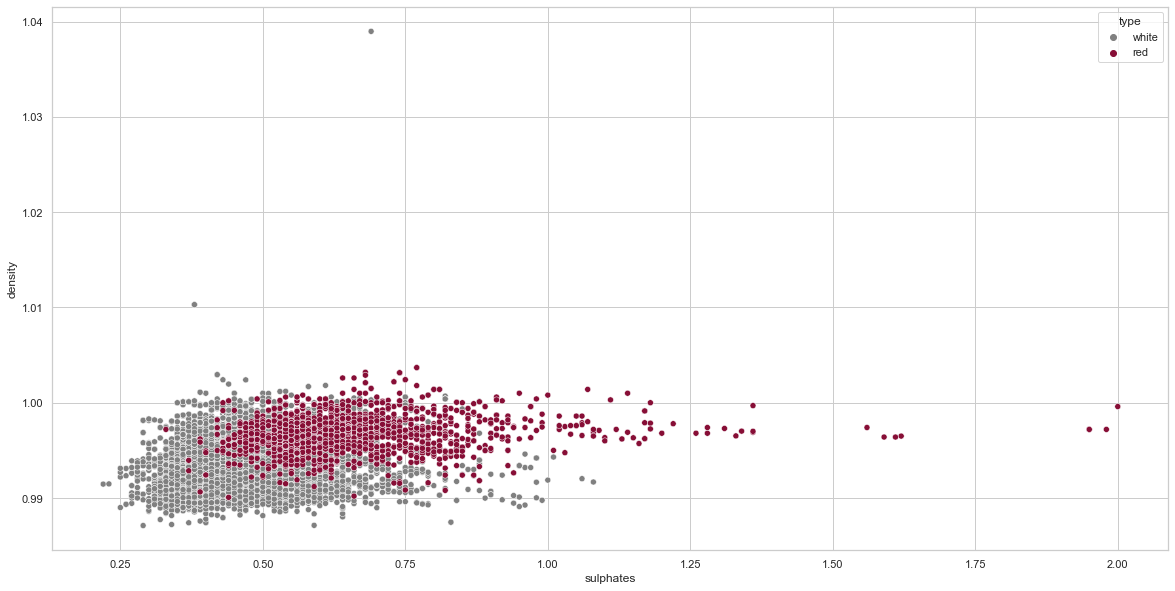

In [52]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='sulphates', y='density', hue='type', palette=g_r_palette)
plt.show()

**Correlation: 26%** <br>
Sulfites are also one of the reasons why the density of wine increases. However, in this graph it is not fully represented either. Even so, the correlation between both columns is not null.

### 4.2.12  Alcohol - C₂H₅OH

The wine itself is the result of a chemical process known as fermentation, which transforms the must or grape juice. As we have already told you, wine is the result of the alcoholic fermentation that takes place, in which the sugar naturally contained in the must (sugar naturally present in the grape), is converted into ethyl alcohol, thanks to the action of the yeasts. Thus, this sugar is transformed into alcohol, we can say that the yeasts are consuming this sugar and generating alcohol. This attribute is expressed in alcohol by volume in the dataset.

Mean:  10.491800831149455


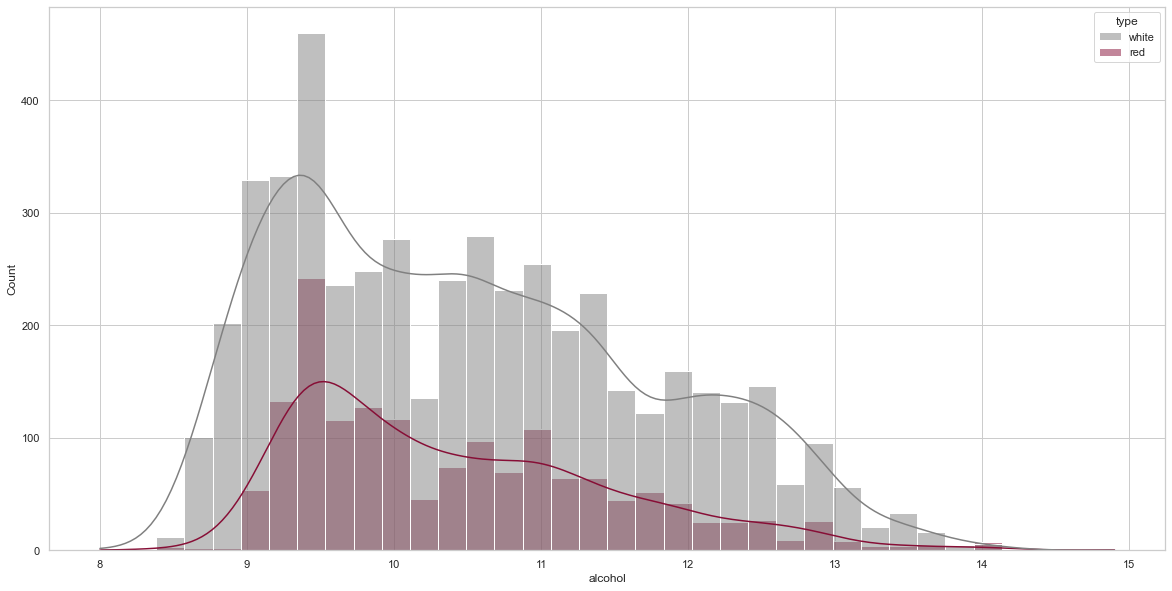

In [53]:
plt.figure(figsize=(20,10))
sns.histplot(data = wine_raw, x = "alcohol", hue = "type", kde = True, palette=g_r_palette)
print("Mean: ", wine_raw['alcohol'].mean())

Surprisingly, both types of wine follow the same pattern of alcohol content. Most commonly, the wines are between 9 and 15 degrees, although, of course, there are different variations. When the fruit ripens, it produces sugars which, as we have seen before, will be transformed into alcohol. It is logical, then, to understand that the higher the temperature, the greater the ripening and, therefore, the greater the amount of sugar, which translates into a higher alcohol content.

<AxesSubplot:xlabel='type', ylabel='alcohol'>

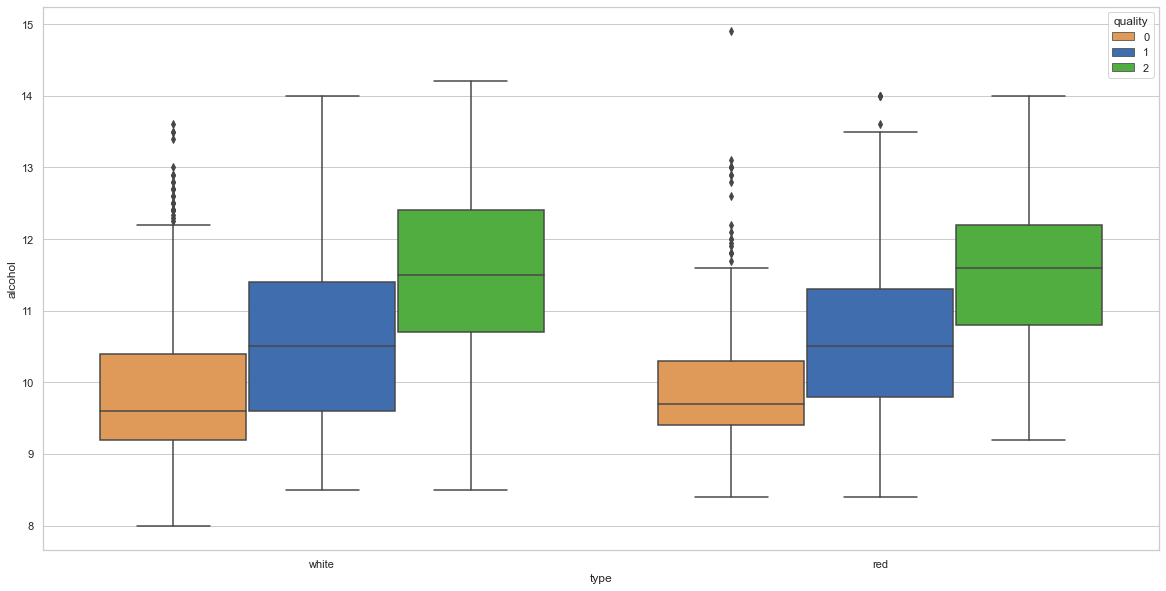

In [54]:
fig = plt.figure(figsize = (20,10))
sns.boxplot(x = 'type', y = 'alcohol', hue="quality", palette=quality_colors, data = wine_raw)

Due to the alcohol having a lower density than the wine, the % of volume of alcohol it is inverseley proportional to the density of the wine. Red wines tend to be a little denser than white wines, having very similar % vol of alcohol, ranging from 8% to 15%. There propably is an outlier with a higher density than normal.

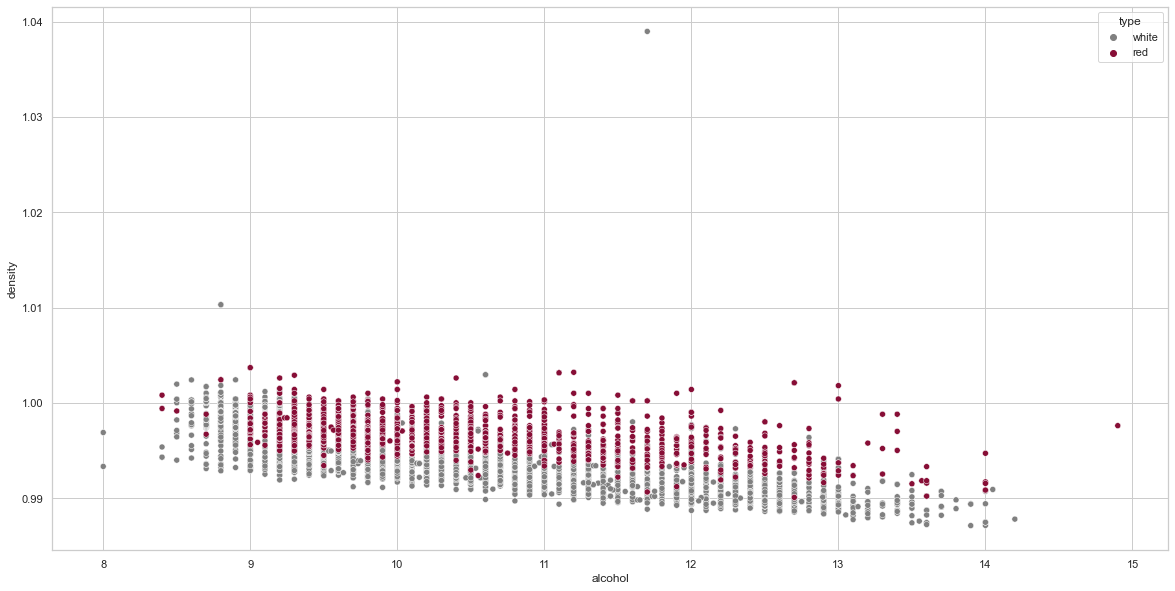

In [55]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=wine_raw, x='alcohol', y='density', hue='type', palette = g_r_palette)
plt.show()

**Correlation: -69%** <br>
In general, alcohol does not show a very good correlation with the rest of the columns (except `quality` and `density`). Quality tends to be directly proportional to alcohol content, and density tends to be inverseley proportional to alcohol content.

### 4.2.13  Quality

It is the value that we want to predict from the rest of the features. The quality assigned to each wine has been selected by wine experts. The eventual quality score is the median of at least three evaluations made by the same wine experts.

<AxesSubplot:xlabel='quality', ylabel='Count'>

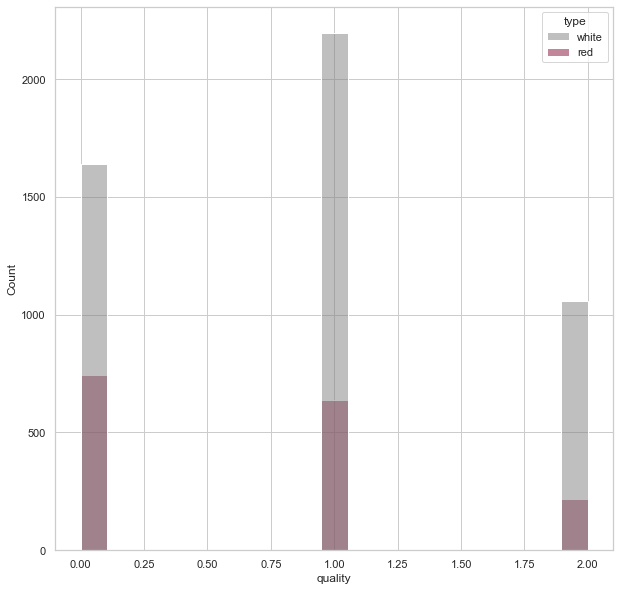

In [56]:
plt.figure(figsize=(10,10))
sns.histplot(data = wine_raw, x = 'quality', hue = 'type', palette = g_r_palette )

As we have already mentioned, the medium quality is the one that collects the largest number of values and the high quality is the one that has the fewest entries.

## 4.3  Relevant Observations

* As we have seen, in most cases the two types of wine are quite different. The information varies so much that it could be divided into two different datasets and there would be hardly any relationship between them. It can be concluded that the type of wine is a very relevant attribute when studying the rest of the wine characteristics.
* Certain irrational outliers have been observed in features such as `citric acid` or `chlorides`. These can affect the behaviour of the model to be used, so we might consider eliminating them.
* The column that most determines wine quality is `alcohol`, so we can determine that it is a very important feature when predicting the quality of a wine.
* On the other hand, one of the columns that correlates least with quality is `pH`, whose correlation is almost 0. Although it correlates better with other columns, it may be a possibility to discard this feature altogether and not take it into account during the modelling.
* As mentioned above, `density` has a lot to do with wine glucose. Therefore, it is not by chance that this column and `residual sugar` are one of the best correlated of the whole dataset (55%). Also `density` and `alcohol`presents a high accuracy (69%). We do not take into account the high correlation between `total sulphur dioxide` and `free sulphur dioxide` because in reality the first one already includes the data from the second one.
* Although the predominant quality is medium, on several occasions we have been able to see differences between features of different qualities. This will help the model to really know how to differentiate between one quality and another and to find the appropriate contrasts.


# 5  First Iteration

## 5.1  Data Preparation

In this first iteration, a basic data preparation will be applied to work with the data correctly. On the one hand, all those rows with some attribute with a null value will be eliminated. And the most outstanding outliers of each attribute will be deleted using Percentile Capping. In addition, the wine types will be replaced by two different numerical values (essential to be able to use the model).

### 5.1.1  Removing Null Values

In [57]:
wine_raw.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [58]:
wine_processed = wine_raw.copy(deep=True).dropna()
wine_processed.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 5.1.2  Applying Percentile Capping to Remove Outliers

At first, we tried the IQR method, but it removed a lot of outliers given the distribution of our dataset, so we ended up modifying the cuartiles values, from 25% to only 3,5%. We are removing the outliers on the 3,5% of the lowest and highest values in each column. We have tried to cover a higher percentage but if we do that we eliminate practically all 0 and 2 quality wines due to the imprecision of the outliers. Therefore, we have decided to remove only the most exaggerated outliers in the dataset.

In [59]:
wine_pc = wine_processed.copy(deep = True)
Q1 = wine_pc.quantile(0.035)
Q3 = wine_pc.quantile(0.965)
IQR = Q3 - Q1
print(IQR)

fixed acidity             4.70000
volatile acidity          0.56500
citric acid               0.59000
residual sugar           14.90000
chlorides                 0.08800
free sulfur dioxide      59.00000
total sulfur dioxide    197.00000
density                   0.01011
pH                        0.58000
sulphates                 0.50000
alcohol                   3.98300
quality                   2.00000
dtype: float64


In [60]:
print(Q1)

fixed acidity            5.6000
volatile acidity         0.1500
citric acid              0.0200
residual sugar           1.1000
chlorides                0.0260
free sulfur dioxide      5.0000
total sulfur dioxide    16.0000
density                  0.9896
pH                       2.9500
sulphates                0.3300
alcohol                  8.8170
quality                  0.0000
Name: 0.035, dtype: float64


In [61]:
print((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR)))

      alcohol  chlorides  citric acid  density  fixed acidity  \
0       False      False        False    False          False   
1       False      False        False    False          False   
2       False      False        False    False          False   
3       False      False        False    False          False   
4       False      False        False    False          False   
...       ...        ...          ...      ...            ...   
6491    False      False        False    False          False   
6492    False      False        False    False          False   
6494    False      False        False    False          False   
6495    False      False        False    False          False   
6496    False      False        False    False          False   

      free sulfur dioxide     pH  quality  residual sugar  sulphates  \
0                   False  False    False           False      False   
1                   False  False    False           False      False   
2  

/var/folders/2k/vmp3ttk14jnf4p20cvqxtfhh0000gn/T/ipykernel_91604/1911296124.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  print((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR)))


In [62]:
wine_pc_out = wine_pc.copy(deep = True)
wine_pc_out = wine_pc_out[~((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR))).any(axis=1)]
print(wine_pc_out.shape)

(6424, 13)


/var/folders/2k/vmp3ttk14jnf4p20cvqxtfhh0000gn/T/ipykernel_91604/1784630315.py:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  wine_pc_out = wine_pc_out[~((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR))).any(axis=1)]


In [63]:
i, _ = wine_processed.shape
o, _ = wine_pc_out.shape
print("Removed", i-o,"rows")
print("Rows count reduced from", i, "to", o,"resulting in", int((o/i)*100), "% of the initial rows" )

Removed 39 rows
Rows count reduced from 6463 to 6424 resulting in 99 % of the initial rows


In [64]:
wine_pc_out.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6424.000000,6424.000000,6424.000000,6424.000000,6424.000000,6424.000000,6424.00000,6424.000000,6424.000000,6424.000000,6424.000000,6424.000000
mean,7.212274,0.338376,0.317771,5.449922,0.054492,30.548023,115.85811,0.994679,3.219029,0.527768,10.497561,0.832503
std,1.297787,0.163315,0.143461,4.702846,0.026651,17.466090,56.32727,0.002953,0.160412,0.138692,1.193907,0.731380
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.00000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.00000,0.992300,3.110000,0.430000,9.500000,0.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.00000,0.994860,3.210000,0.510000,10.300000,1.000000
75%,7.700000,0.400000,0.390000,8.100000,0.064000,41.000000,156.00000,0.996980,3.320000,0.600000,11.300000,1.000000
max,15.900000,1.330000,1.230000,31.600000,0.244000,146.500000,366.50000,1.010300,4.010000,1.560000,14.900000,2.000000


### 5.1.3  Substitution of Type of Wine

Here we substitute white wine by the value 0 and red wine with the value 1.

In [65]:
wine_pc_type = wine_pc_out.copy(deep = True)
wine_pc_type = wine_pc_type.replace({'type': {"white": 0, "red": 1}})
wine_pc_type['type'].value_counts()

0    4862
1    1562
Name: type, dtype: int64

### 5.1.4  Train-test Split

We sepparate the dataframe in 4 dataframes, test and split, each one with all the attributes except the quality, we call it x, and y for only the quality columns that we are going to predict. The test dataset has a 30% of the rows of the original dataset, and the train dataset, a 70% of them.

In [66]:
x = wine_pc_type.drop(['quality'], axis=1)
y = wine_pc_type['quality']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

In [67]:
y_train.describe()

count    4496.000000
mean        0.844528
std         0.731969
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: quality, dtype: float64

<AxesSubplot:xlabel='quality', ylabel='Count'>

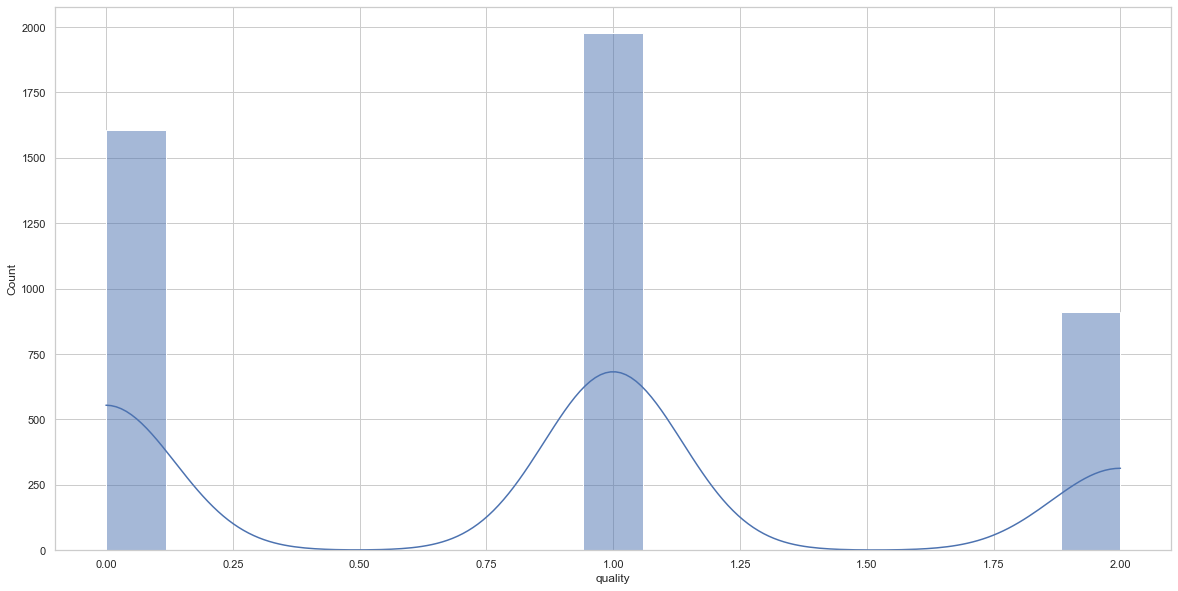

In [68]:
plt.figure(figsize=(20,10))
sns.histplot(data = y_train, kde = True, palette=g_r_palette)


In [69]:
X_train.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000,4496.000000
mean,0.241770,7.196864,0.337905,0.317987,5.461788,0.054343,30.652580,115.864880,0.994643,3.218416,0.527467,10.517742
std,0.428204,1.285452,0.163723,0.142932,4.686609,0.026479,17.513372,56.231636,0.002964,0.160538,0.138656,1.198763
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000
25%,0.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,78.000000,0.992235,3.110000,0.430000,9.500000
50%,0.000000,7.000000,0.290000,0.310000,3.200000,0.047000,29.000000,118.000000,0.994800,3.210000,0.500000,10.400000
75%,0.000000,7.625000,0.400000,0.390000,8.200000,0.064000,41.125000,155.000000,0.996900,3.320000,0.600000,11.300000
max,1.000000,15.900000,1.330000,1.230000,31.600000,0.244000,146.500000,366.500000,1.010300,4.010000,1.360000,14.900000


In [70]:
X_test.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000,1928.000000
mean,0.246369,7.248211,0.339476,0.317267,5.422251,0.054838,30.304201,115.842324,0.994762,3.220456,0.528470,10.450498
std,0.431008,1.325747,0.162398,0.144722,4.741601,0.027050,17.357408,56.564272,0.002927,0.160150,0.138809,1.181477
min,0.000000,4.200000,0.085000,0.000000,0.800000,0.012000,1.000000,6.000000,0.987130,2.770000,0.250000,8.000000
25%,0.000000,6.400000,0.230000,0.240000,1.800000,0.037750,17.000000,78.000000,0.992400,3.110000,0.430000,9.500000
50%,0.000000,7.000000,0.290000,0.310000,2.900000,0.047000,29.000000,119.000000,0.994995,3.210000,0.510000,10.200000
75%,0.000000,7.700000,0.400000,0.390000,8.000000,0.064000,41.000000,157.000000,0.997053,3.320000,0.600000,11.200000
max,1.000000,15.600000,1.130000,1.000000,22.600000,0.235000,122.500000,344.000000,1.003690,3.810000,1.560000,14.000000


In [71]:
y_train.describe()

count    4496.000000
mean        0.844528
std         0.731969
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: quality, dtype: float64

In [72]:
y_test.describe()

count    1928.000000
mean        0.804461
std         0.729425
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: quality, dtype: float64

## 5.2  Modeling &amp; Evaluation

### 5.2.1  Logistic Regression

Logistic regression is useful for cases where you want to predict the presence or absence of a characteristic or outcome based on the values of a set of predictors, similar to a linear regression model. This allows the analysis of the results in explanatory and predictive terms. We decided to use it because is a basic and useful analysis method for classification problems, it is very easy to realize and achieves a normal performance with linearly separable classes. It is an extensively employed algorithm for classification in industry.



In [73]:
lr = LogisticRegression(random_state=40)
print(lr.get_params())

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': 40, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [74]:
lr.fit(X_train,y_train)

/opt/homebrew/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=40)

In [75]:
y_pred = lr.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print('Accuracy: {:d}%'.format(int(accuracy * 100)))

Accuracy: 51%


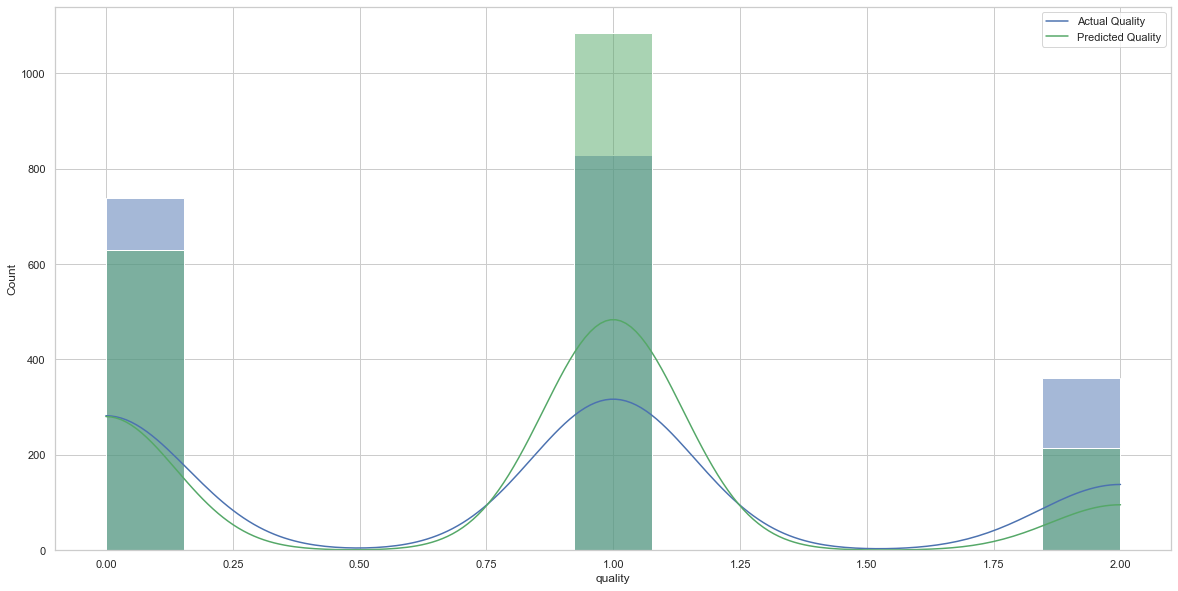

In [76]:
plt.figure(figsize=(20,10))
sns.histplot(data = y_test, kde = True, color='b')
sns.histplot(data = y_pred, kde = True, color='g')
plt.legend(labels=["Actual Quality","Predicted Quality"])


### 5.2.2  Performance Evaluation (Accuracy and Confusion Matrix)

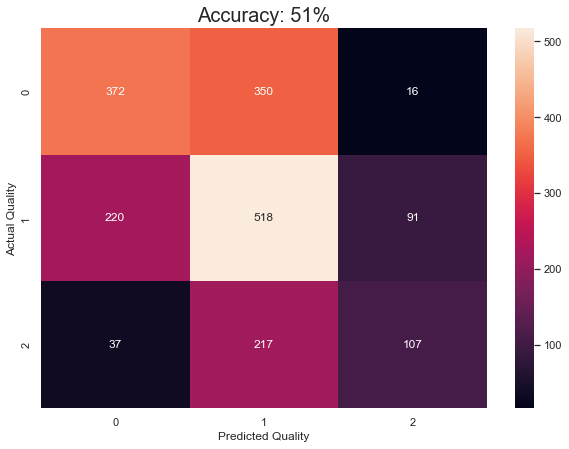

In [77]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Accuracy: {:d}%'.format(int(accuracy * 100)), size = 20)
plt.show()

As a metric we are using `accuracy` and a `confusion matrix` with the changes on the quality column, our target column. The accuracy achieved is relatively hight (51%), even though it can be imporived with a deeper data preparation, and a more adecuate model for our dataset (a 33.33% accuracy would mean that the model hasn't learned).

In the confusion matrix we can see that there are quite a number of well predicted values, especially for quality 1. However, the model has some significant errors: it confuses many actual values 1 for 0 and actual values 2 for 1 values (allways for the closest values), the rest are more insignificant mistakes. It overpredicts the medium value 1, possibly due to underfitting, mainly on the values 0 and 2. Some possible errors affecting the score may be the lack of outliers removed or the fact that all features have been used in the model. In fact, for classification problems there are other types of models that may be better suited to our problem.

### 5.2.3  Following Iteration

In the next iteration we aim to improve the accuracy by reconsidering the way we have treated the data, as well as applying a different model that better fits our problem.

We'll try other methods of treatment for the null values instead of removing the whole line. We'll replace null values with the median of each column. We will also investigate which column(s) could be eliminated for better accuracy. However, it seems that the model does not work very well with our dataset. The most important change would be to change the model used, so decision tree and random forest models will be used, which are likely to be better suited to the current problem (a clasification one). Those changes should help the following models to learn in a better way.

# 6  Second Iteration

## 6.1  Data Preparation

### 6.1.1  Remove Features

As we have already seen in the Column Study, `chlorides` is one of the attributes whose value is very similar in the three qualities, and it also presents too many outliers. The hypothesis is that it may be a column that negatively affects the model: it is not able to differentiate the quality of the wine through this feature. Therefore, it has been decided to eliminate this column and check if the results improve.

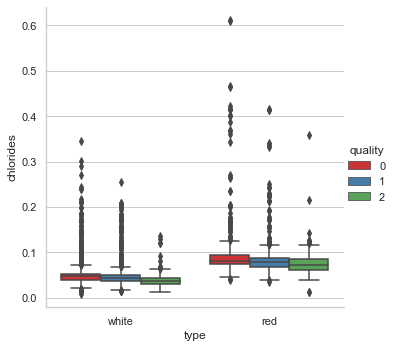

In [78]:
sns.catplot(x = "type", y="chlorides", hue="quality", data=wine_raw, kind="box", palette="Set1")

In [79]:
wine_dropf = wine_raw.copy(deep = True)
wine_dropf = wine_dropf.drop(['chlorides'], axis=1)

In [80]:
wine_dropf

,type,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,white,6.3,0.300,0.34,1.6,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,white,8.1,0.280,0.40,6.9,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,white,7.2,0.230,0.32,8.5,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,white,7.2,0.230,0.32,8.5,47.0,186.0,0.99560,3.19,0.40,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,32.0,44.0,0.99490,3.45,0.58,10.5,0
6493,red,5.9,0.550,0.10,2.2,39.0,51.0,0.99512,3.52,NaN,11.2,1
6494,red,6.3,0.510,0.13,2.3,29.0,40.0,0.99574,3.42,0.75,11.0,1
6495,red,5.9,0.645,0.12,2.0,32.0,44.0,0.99547,3.57,0.71,10.2,0


### 6.1.2  Filling Null Values With Median

Unlike the previous iteration, in this case the null values will be filled by the median of each column so that no rows are lost.

In [81]:
wine_dropf.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [82]:
wine_processed = wine_dropf.copy(deep = True)
wine_processed['fixed acidity'].fillna(wine_processed['fixed acidity'].median(), inplace=True)
wine_processed['volatile acidity'].fillna(wine_processed['volatile acidity'].median(), inplace=True)
wine_processed['citric acid'].fillna(wine_processed['citric acid'].median(), inplace=True)
wine_processed['residual sugar'].fillna(wine_processed['residual sugar'].median(), inplace=True)
wine_processed['pH'].fillna(wine_processed['pH'].median(), inplace=True)
wine_processed['sulphates'].fillna(wine_processed['sulphates'].median(), inplace=True)
wine_processed.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

### 6.1.3  Applying Percentile Capping to Remove Outliers

As in the last iteration, we use Percentile Capping to remove the most prominent outliers.

In [83]:
wine_pc = wine_processed.copy(deep = True)
Q1 = wine_pc.quantile(0.05) # 0.035
Q3 = wine_pc.quantile(0.95) # 0.965
IQR = Q3 - Q1
print(IQR)

fixed acidity             4.100000
volatile acidity          0.510000
citric acid               0.510000
residual sugar           13.800000
free sulfur dioxide      55.000000
total sulfur dioxide    187.000000
density                   0.009492
pH                        0.530000
sulphates                 0.440000
alcohol                   3.700000
quality                   2.000000
dtype: float64


In [84]:
wine_pc_out = wine_pc[~((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR))).any(axis=1)]

/var/folders/2k/vmp3ttk14jnf4p20cvqxtfhh0000gn/T/ipykernel_91604/1873170750.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  wine_pc_out = wine_pc[~((wine_pc < (Q1 - 1.5 * IQR)) |(wine_pc > (Q3 + 1.5 * IQR))).any(axis=1)]


In [85]:
i, _ = wine_processed.shape
o, _ = wine_pc_out.shape
print("Removed", i-o,"rows")
print("Rows count reduced from", i, "to", o,"resulting in", int((o/i)*100), "% of the initial rows" )

Removed 13 rows
Rows count reduced from 6497 to 6484 resulting in 99 % of the initial rows


### 6.1.4  Substitution of Type of Wine

Here we substitute white wine by the value 0 and red wine with the value 1, as we have done in the first iteration.

In [86]:
wine_pc_out = wine_pc_out.replace({'type': {"white": 0, "red": 1}})
wine_pc_out['type'].value_counts()

0    4894
1    1590
Name: type, dtype: int64

### 6.1.5  Train-test Split

As before, we sepparate the dataframe in 4 dataframes, test and split, each one with all the attributes except the quality, we call it x, and y for only the quality columns that we are going to predict. The test dataset has a 30% of the rows of the original dataset, and the train dataset, a 70% of them.

In [87]:
x = wine_pc_out.drop(['quality'], axis=1)
y = wine_pc_out['quality']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

## 6.2  Modeling &amp; Evaluation

### 6.2.1  Decision Tree

Decision Tree is a supervised algorithm that uses a tree like model of decisions. This algorithm uses various methods to split the data and choose the best split. In this case, we are using a Gini criterion, that means we are gonna split every column based on the objective column and our model is gonna choose the split with the lowest Gini score.

In [88]:
dt = DecisionTreeClassifier(criterion='gini',splitter='best')
dt.fit(X_train,y_train)

DecisionTreeClassifier()

In [89]:
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print('Accuracy: {:d}%'.format(int(accuracy_dt * 100)))

Accuracy: 64%


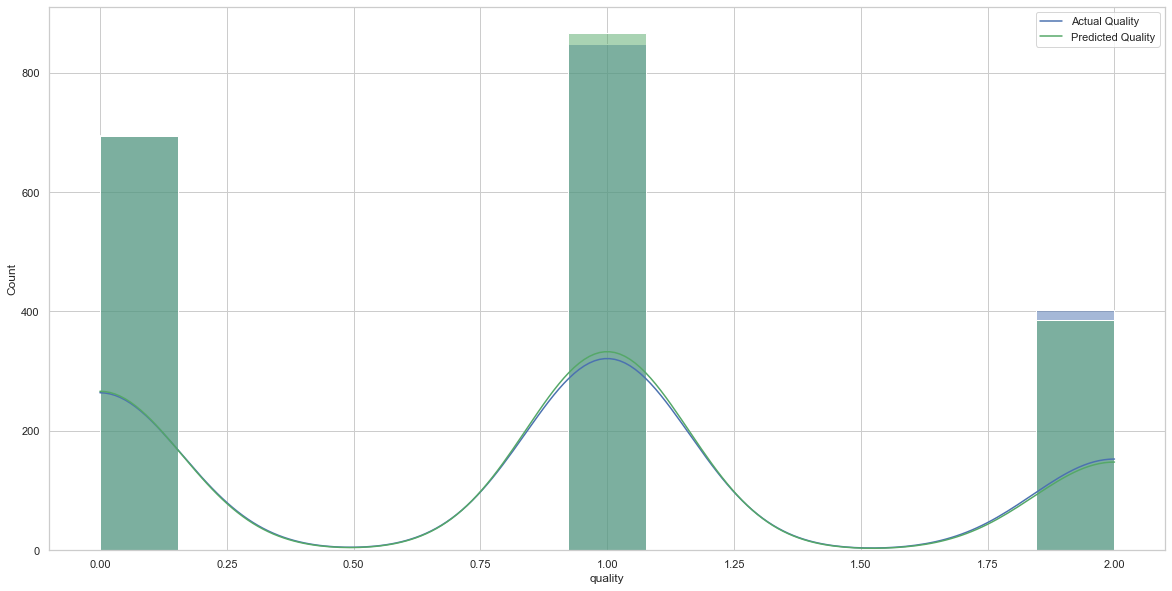

In [90]:
plt.figure(figsize=(20,10))
sns.histplot(data = y_test, kde = True, color='b')
sns.histplot(data = y_pred_dt, kde = True, color='g')
plt.legend(labels=["Actual Quality","Predicted Quality"])

The following `dt2` is a smaller tree (4 leaf maximum) intended just for visualization purposes of what the bigger decision tree of our model would look like. 

In [91]:
dt2 = DecisionTreeClassifier(criterion='gini',splitter='best', max_leaf_nodes=4)
dt2.fit(X_train,y_train)

DecisionTreeClassifier(max_leaf_nodes=4)

In [92]:
column_names = ["type","fixed acidity","volatile acidity", "citric acid","residual sugar","free sulfur dioxide","total sulfur dioxide","density","pH","sulphates","alcohol","quality"]

/opt/homebrew/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


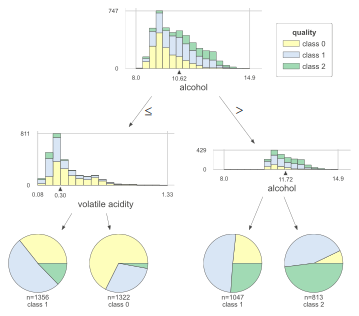

In [93]:
from dtreeviz.trees import dtreeviz ## it might need to be installed with !pip install dtreeviz
viz = dtreeviz(dt2, X_train, y_train, target_name="quality", feature_names=column_names)
viz

### 6.2.2  Random Forest

Random forests is combination of decision trees. The model creates a set of decision trees where it chooses randomly the columns to be split. The predictions are made with the most frequent observation among all the trees.

In [94]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=1000, random_state=0)

In [95]:
y_pred_rfc = rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print('Accuracy: {:d}%'.format(int(accuracy_rfc * 100)))

Accuracy: 71%


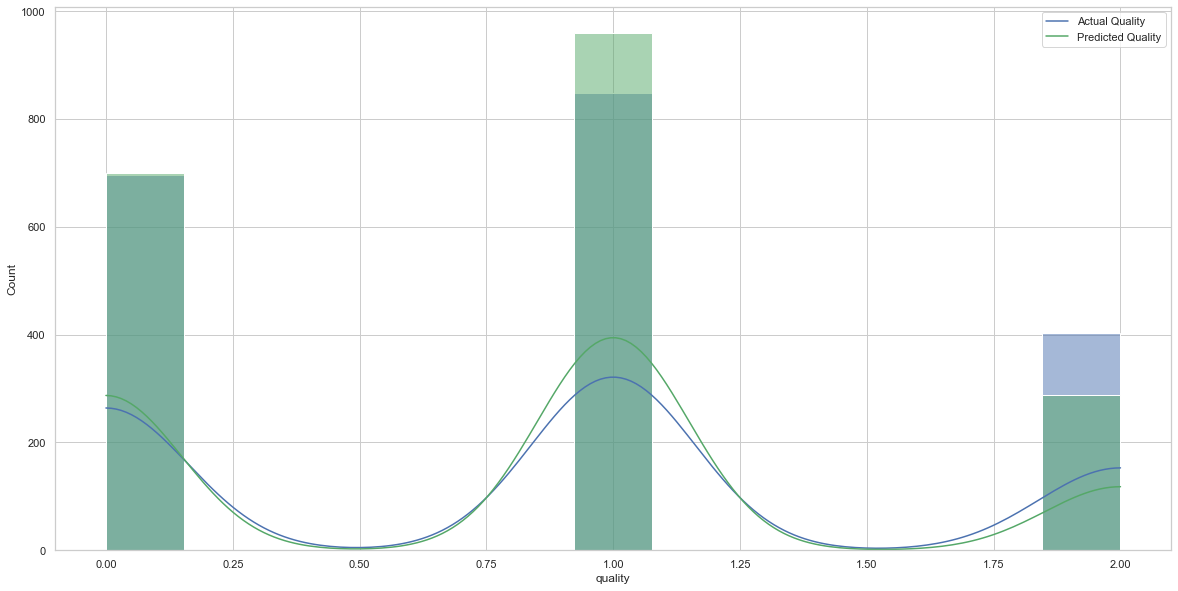

In [96]:
plt.figure(figsize=(20,10))
sns.histplot(data = y_test, kde = True, color='b')
sns.histplot(data = y_pred_rfc, kde = True, color='g')
plt.legend(labels=["Actual Quality","Predicted Quality"])

### 6.2.3  Performance Evaluation (Accuracy and Confusion Matrix)

**Decision Tree**


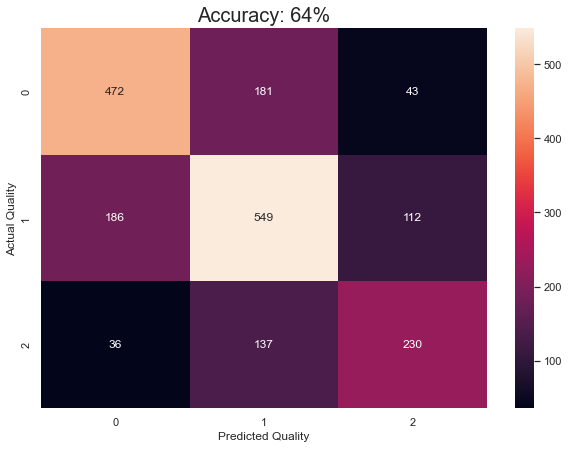

In [97]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Accuracy: {:d}%'.format(int(accuracy_dt * 100)), size = 20)
plt.show()

In this case we also used accuracy and confusion matrix as evaluation. We obtained a better accuracy than in the previous iteration (64% > 51%), and the confusion matrix diagonal is more prominent, it has higher valuess than the rest of the matrix. The model used seems to fit the problem better, and the data preparation has been a little deeper. The confusion matrix shows that there are fewer wrong predictions and, as suggested by the data, quality 1 has a higher number of correct predictions. 

**Random Forest**

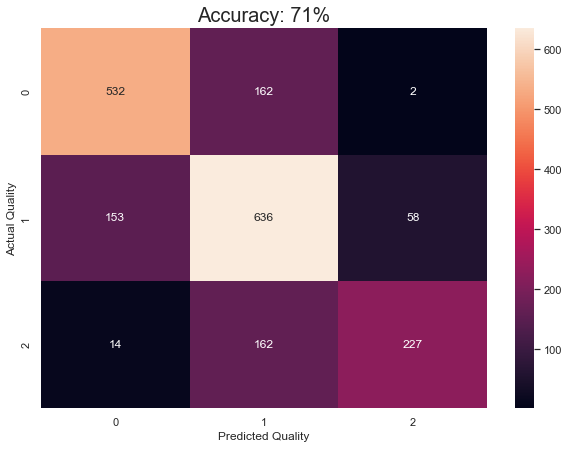

In [98]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Accuracy: {:d}%'.format(int(accuracy_rfc * 100)), size = 20)
plt.show()

We again improved accuracy with this new model (72% > 64%). Random forest works like the decision tree but with several internal iterations, so it was to be expected that the results would improve. The more the model is trained, the more it learns from the data and the better the results will be. The confusion matrix also shows that the model has learned better behaviour, it has better results in every cell except in the actual quality 2 and predicted quality 1.

Both models still seems to be making errors and confusing the qualities 0 and 1, and the qualities 1 and 2. But the Random Forest seems to be better at distinguising between qualities 0 and 2 that are further apart.

Despite the multiple tests we have done, perhaps more columns need to be removed to make the changes more relevant. On the other hand, we think that filling the null values with the median is a wise decision and improves the result.

### 6.2.4  Following Iteration

In the next iteration we will employ a deep learning model to do a more exhaustive run through the data and improve the prediction of wine quality. We believe that such a model will also do a good job of prediction because the use of neurons is usually very effective for this type of problem.

Regarding the data, we have decided to keep the same data preparation as we believe that for a study like this, the modifications applied are sufficient to improve the model. We assume that more precise changes can be made but we consider that this would require too much study for a minimal or even negligible improvement of the accuracy.

# 7  Third Iteration

## 7.1  Data Preparation

In this iteration, we keep the same data preparation as in the previous iteration. That is to say:
- Remove the feature `chlorides`
- Fill null values with the median of the column
- Apply Percentile Capping to remove outliers
- Replace wine types with numerical values

In [99]:
wine_pc_out.to_csv(PATH_DATA_PROCESSED + "numpy_dataframe.csv")

We have exported the pandas dataframe as a CSV file.

## 7.2  Modeling &amp; Evaluation

### 7.2.1  Neural Network (DL)

In [100]:
wine = np.loadtxt(PATH_DATA_PROCESSED + 'numpy_dataframe.csv', delimiter= ",", skiprows=1, usecols=range(1,13))

Now we import the CSV as a numpy ndarray, to complete the conversion from the previous pandas dataframe.
Delimiter is comma because it's a Comma Separated Values file, and Skiprows for skipping the first row with the column names.

In [101]:
print(wine)

[[ 0.     7.     0.27  ...  0.45   8.8    1.   ]
 [ 0.     6.3    0.3   ...  0.49   9.5    1.   ]
 [ 0.     8.1    0.28  ...  0.44  10.1    1.   ]
 ...
 [ 1.     6.3    0.51  ...  0.75  11.     1.   ]
 [ 1.     5.9    0.645 ...  0.71  10.2    0.   ]
 [ 1.     6.     0.31  ...  0.66  11.     1.   ]]


In [102]:
n_features = 11
x = wine[:,:n_features]
y = wine[:, n_features:]

Here we divide de dataset, being `x` all the 11 feautures, and `y` the last column quality

Dataset before scale()


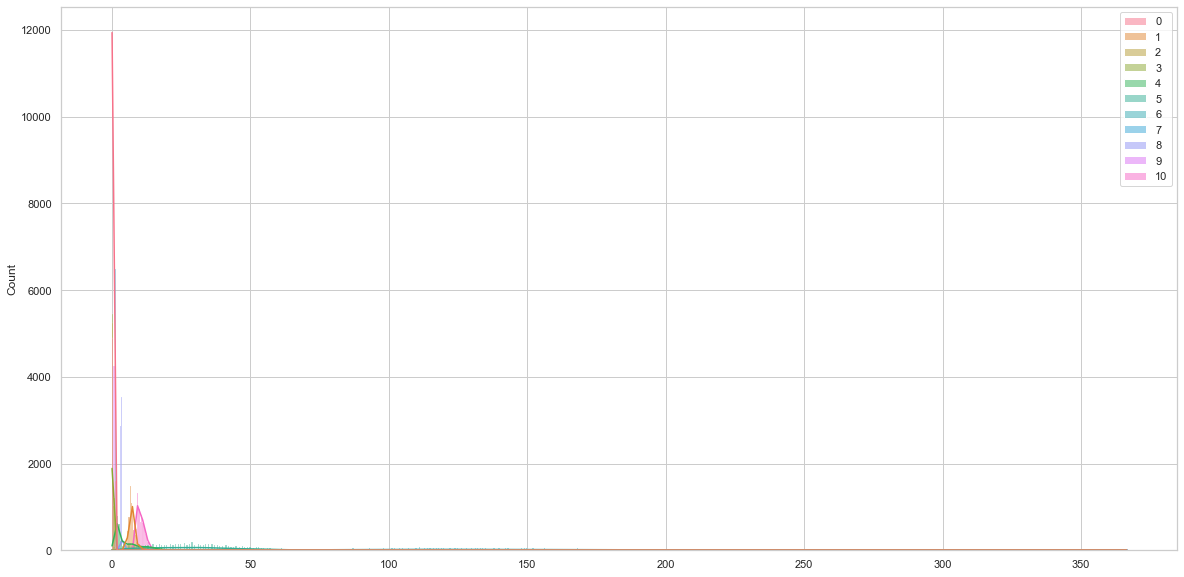

In [103]:
plt.figure(figsize=(20,10))
sns.histplot(data = x, kde = True)
print("Dataset before scale()")

In [104]:
# Standardize the input features
x = scale(x)
# Now we have X - a scaled dataset with all the features

Dataset after applying scale() function


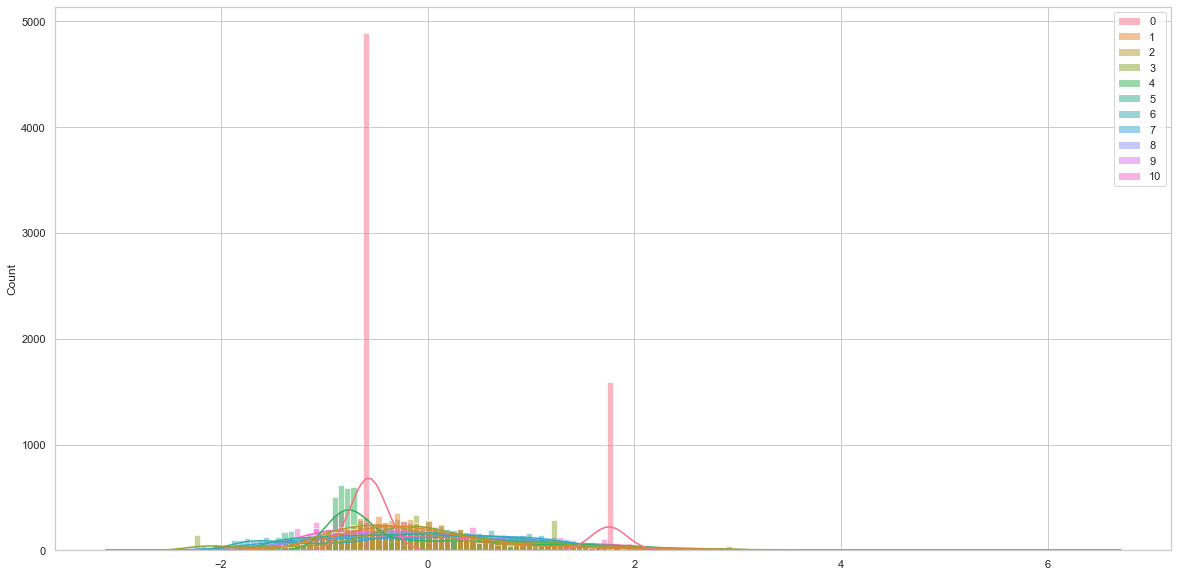

In [105]:
plt.figure(figsize=(20,10))
sns.histplot(data = x, kde = True)
print("Dataset after applying scale() function")

11 Features: `scale()` normalizes the values between a similar range from negateive to positive values in this case. It centers to the mean and component wise scale to unit variance.

Now we start modifying quality

In [106]:
y.shape

(6484, 1)

In [107]:
# Encode categorical features as a one-hot numeric array.
oneHot = OneHotEncoder()
# Fit OneHotEncoder to X, then transform X. Then to an array
y = oneHot.fit_transform(y).toarray()

Quality treatment:

`OneHotEncoder()` creates one column for each of the 3 qualities, only one of the 3 columns will be a 1 and the other 2 columns will be 0, indicating witch quality the row has assigned. 

In [108]:
y.shape

(6484, 3)

In [109]:
print("Quality column after applying OneHotEncoder(), from 1 column and 3 values, to 3 binary columns")
print(y)

Quality column after applying OneHotEncoder(), from 1 column and 3 values, to 3 binary columns
[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [110]:
X_train , X_test , Y_train , Y_test = train_test_split(x , y, test_size = 0.3)
print("Number of train rows:", len(X_train), " -  70%")
print("Number of test rows: ", len(X_test), " -  30%")

Number of train rows: 4538  -  70%
Number of test rows:  1946  -  30%


Now we can split the data in train and test datasets

In [111]:
print(x)

[[-0.56998914 -0.16583336 -0.42250066 ... -1.36266206 -0.56072109
  -1.4185158 ]
 [-0.56998914 -0.70591477 -0.2391322  ...  0.50762825 -0.27916096
  -0.83177715]
 [-0.56998914  0.682866   -0.36137784 ...  0.25825621 -0.63111112
  -0.3288583 ]
 ...
 [ 1.7544194  -0.70591477  1.04444704 ...  1.25574438  1.55097988
   0.42551997]
 [ 1.7544194  -1.01453272  1.86960512 ...  2.19088953  1.26941975
  -0.2450385 ]
 [ 1.7544194  -0.93737823 -0.17800937 ...  1.06871535  0.91746959
   0.42551997]]


In [112]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN , self).__init__()
        
        self.layer1 = nn.Linear(n_features , n_features)
        self.layer2 = nn.Linear(n_features , 3)

        # IL -  HL  - OL
        # 11 -  11  - 3
        
        # Forward pass function
    def forward(self , data):
        
        # Layer 1
        activation1 = self.layer1(data)
        
        # Activation function
        activation1 = torch.sigmoid(activation1)
        
        # Layer 2
        activation2 = self.layer2(activation1)
        
        # Return the output activation on the sigmoid
        return torch.sigmoid(activation2)

Our neural network has three layers:

- `Input Layer` with 11 neurons (the number of features entered)
- `Hidden Layer` with another 11 neurons
- `Output Layer` with 3 neurons (the three possible qualities) 

For these layers we use the sigmoid activation function, which aims to return an output from an input value. In this case, this activation function returns a value of 1 or 0 if the input is positive or negative.

In [113]:
# Define the model instance created above
model = FCN()

In [114]:
# Define the criterion 
criterion = nn.BCELoss()

In [115]:
# Applying Gradient Decent optimization algorithm
optimizer = optim.SGD(model.parameters() , lr = 0.2)

In [116]:
# Convert the numpy to tensor
X = Variable(torch.from_numpy(X_train).float())
Y = Variable(torch.from_numpy(Y_train).float())

In [117]:
# Arrays for the losses and accuracy.
n = 0
losses = []
train_acc = []
test_acc = []

In [118]:
# TRAIN iterates the data 30000 times
for epoch in range(30000):
    
    # Forward pass
    out = model(X)
    loss = criterion(out , Y)
    losses.append(loss.data)
    
    # Optimizer
    optimizer.zero_grad()
    
    # Back propagation
    loss.backward()
    optimizer.step()
    
    # Save the training accuracy to the train_acc array for doing the graphs later
    train_acc.append(accuracy_score(oneHot.inverse_transform(Y), oneHot.inverse_transform(model(X).data.numpy())))

    if epoch % 500 == 0:
        print(epoch, loss.data)


0 tensor(0.7235)
500 tensor(0.5536)
1000 tensor(0.5311)
1500 tensor(0.5270)
2000 tensor(0.5258)
2500 tensor(0.5251)
3000 tensor(0.5245)
3500 tensor(0.5238)
4000 tensor(0.5231)
4500 tensor(0.5222)
5000 tensor(0.5213)
5500 tensor(0.5203)
6000 tensor(0.5190)
6500 tensor(0.5177)
7000 tensor(0.5163)
7500 tensor(0.5149)
8000 tensor(0.5135)
8500 tensor(0.5121)
9000 tensor(0.5108)
9500 tensor(0.5096)
10000 tensor(0.5085)
10500 tensor(0.5074)
11000 tensor(0.5065)
11500 tensor(0.5056)
12000 tensor(0.5047)
12500 tensor(0.5040)
13000 tensor(0.5033)
13500 tensor(0.5026)
14000 tensor(0.5020)
14500 tensor(0.5014)
15000 tensor(0.5009)
15500 tensor(0.5004)
16000 tensor(0.4999)
16500 tensor(0.4994)
17000 tensor(0.4990)
17500 tensor(0.4985)
18000 tensor(0.4981)
18500 tensor(0.4976)
19000 tensor(0.4972)
19500 tensor(0.4968)
20000 tensor(0.4963)
20500 tensor(0.4959)
21000 tensor(0.4955)
21500 tensor(0.4952)
22000 tensor(0.4948)
22500 tensor(0.4944)
23000 tensor(0.4941)
23500 tensor(0.4938)
24000 tensor(0.4

* Criterions are helpful to train a neural network. Given an input and a target, they compute a gradient according to a given loss function. Loss functions are used to gauge the error between the prediction output and the provided target value. A loss function tells us how far the algorithm model is from realizing the expected outcome. 'loss’ means the penalty that the model gets for failing to yield the desired results.

* The optimizer takes the parameters we want to update, the learning rate we want to use (and possibly many other parameters as well), and performs the updates through its step() method. Simply it is the method to update various hyperparameters that can reduce the losses in much less effort.

*  Back propagation calculates the derivative of "output" respect a change in "loss". To optimize weights of parameters in the neural network, we need to compute the derivatives of our loss function with respect to parameter. Calling .backward() mutiple times accumulates the gradient (by addition) for each parameter. All optimizers implement a step() method, that updates the parameters.

* Finally, to save the current training information and accumulate the learned knowledge, .append is used for the loss values.

### 7.2.2  Performance Evaluation (Accuracy and Confusion Matrix) 

In [119]:
train_out = oneHot.inverse_transform(model(X).data.numpy())
train_accuracy_obtained = accuracy_score(oneHot.inverse_transform(Y), train_out)
print('Training accuracy', train_accuracy_obtained*100)

test_out = oneHot.inverse_transform(model(torch.from_numpy(X_test).float()).data.numpy())
test_accuracy_obtained = accuracy_score(oneHot.inverse_transform(Y_test), test_out)
print('Prediction accuracy', test_accuracy_obtained*100)


Training accuracy 61.8554429263993
Prediction accuracy 58.78725590955807


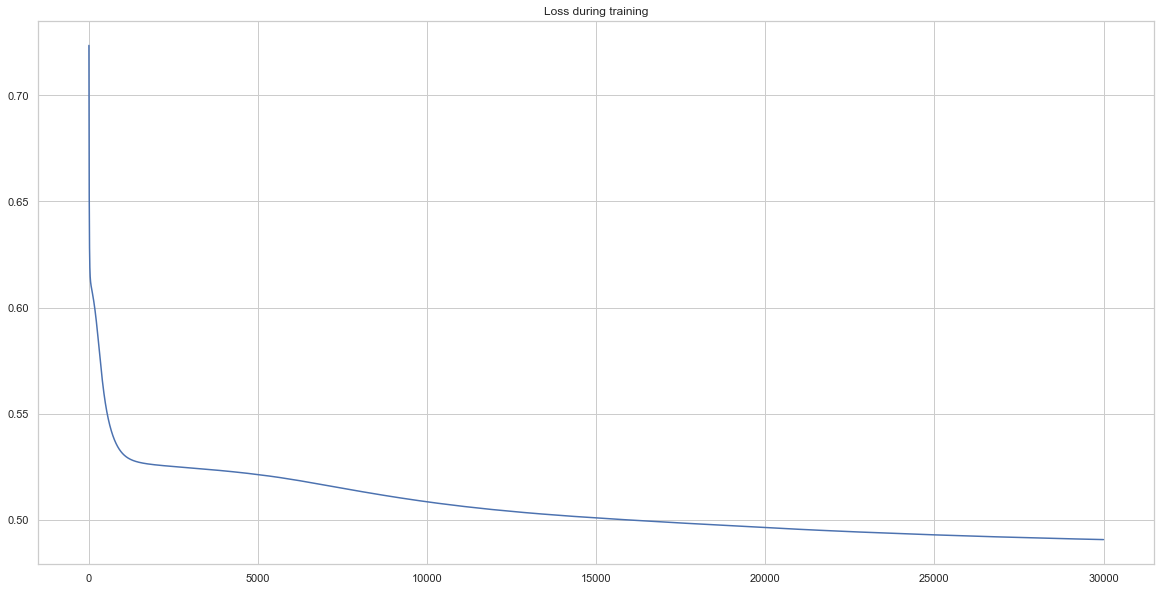

In [120]:
plt.figure(figsize=(20,10))
plt.plot(losses)
plt.title("Loss during training")
plt.show()

As this graph shows, the loss value decreases as the model is trained. With this we can show that it is actually learning from the current data and, in the last iteration, the lowest loss is reached.

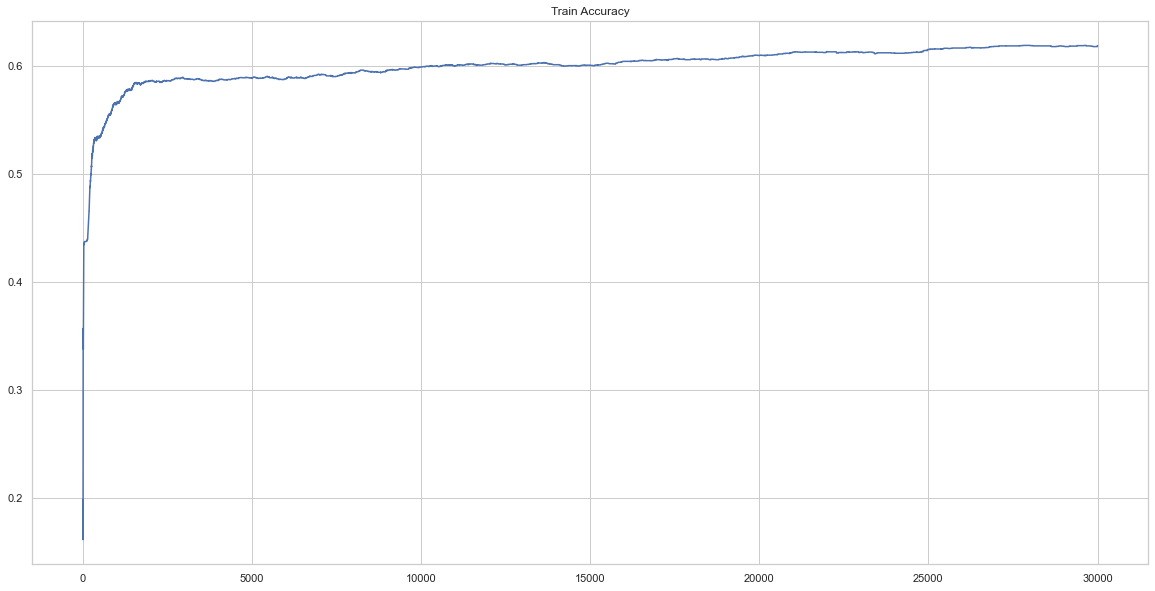

In [121]:
plt.figure(figsize=(20,10))
plt.plot(train_acc)
plt.title("Train Accuracy")
plt.show()

As it can be seen, the train accuracy increases significantly at first, and it keeps ascending slowly until the end of the training. 

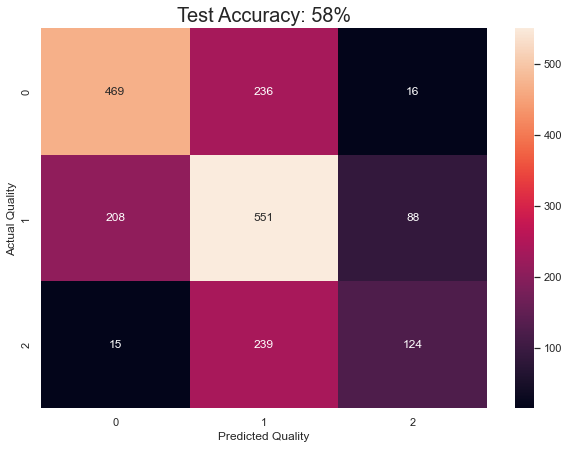

In [122]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(oneHot.inverse_transform(Y_test), test_out), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Test Accuracy: {:d}%'.format(int(test_accuracy_obtained * 100)), size = 20)
plt.show()

The accuracy does not even exceed the result obtained using random forest (59% < 71%). Even so, the results are quite favourable and the model actually learns from the data. The behaviour is similar to the previous situations: quality 1 is the one that predominates and confuses the qualities 0 and 2 quite a lot, so much so that the diagonal in the confusion matrix is not well marked, with more failures than successes.

A possible improvement would be to dig deeper into the neural network and improve it internally, for example by using hyperparameters. On the other hand, we believe that keeping the same data preparation as the previous iteration is a good idea.

# 8  Additional Tests

## 8.1  Dataset of Only One Type of Wine

We have been able to verify that several attributes are very different if they are compared between wines of different types. By mixing both types of wine in the same dataset and treating them equally in a model, the accuracy can be be negatively affected. The fact that scattered data of the same attribute is mixed makes the range of values larger.

The hypothesis is that, since the type of wine is a very significant attribute, working with only one type of wine (without mixing them together) would increase the accuracy. It will be verified below using the same data preparation, modeling (random forest) & evaluation of the second iteration but with different datasets, one for white wine and the other for red wine. The sizes will be relatively different because 75% of the data is for white wine.

### 8.1.1  White Wine

In [123]:
# White wine
white_wine = wine_pc_out.copy(deep = True)
white_wine = white_wine.drop(white_wine[white_wine['type']== 1].index)
white_wine = white_wine.drop("type",axis=1)
white_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,45.0,170.0,1.00100,3.00,0.45,8.8,1
1,6.3,0.30,0.34,1.6,14.0,132.0,0.99400,3.30,0.49,9.5,1
2,8.1,0.28,0.40,6.9,30.0,97.0,0.99510,3.26,0.44,10.1,1
3,7.2,0.23,0.32,8.5,47.0,186.0,0.99560,3.19,0.40,9.9,1
4,7.2,0.23,0.32,8.5,47.0,186.0,0.99560,3.19,0.40,9.9,1
...,...,...,...,...,...,...,...,...,...,...,...
4893,6.2,0.21,0.29,1.6,24.0,92.0,0.99114,3.27,0.50,11.2,1
4894,6.6,0.32,0.36,8.0,57.0,168.0,0.99490,3.15,0.46,9.6,0
4895,6.5,0.29,0.19,1.2,30.0,111.0,0.99254,2.99,0.46,9.4,1
4896,5.5,0.29,0.30,1.1,20.0,110.0,0.98869,3.34,0.38,12.8,2


In [124]:
W_x = white_wine.drop(['quality'], axis=1)
W_y = white_wine['quality']
W_X_train,W_X_test,W_y_train,W_y_test = train_test_split(W_x,W_y,test_size=0.3,random_state=10)

In [125]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
rfc.fit(W_X_train,W_y_train)

W_y_pred_rfc = rfc.predict(W_X_test)
W_accuracy_rfc = accuracy_score(W_y_test, W_y_pred_rfc)
print('Accuracy: {:d}%'.format(int(W_accuracy_rfc * 100)))

Accuracy: 69%


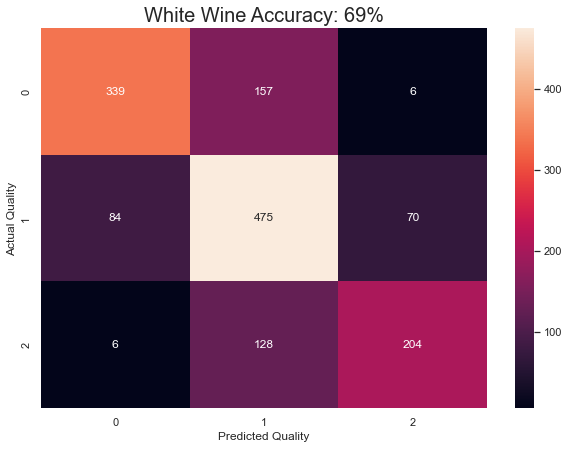

In [126]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(W_y_test, W_y_pred_rfc), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('White Wine Accuracy: {:d}%'.format(int(W_accuracy_rfc * 100)), size = 20)
plt.show()

### 8.1.2  Red Wine

In [127]:
# Red wine
red_wine = wine_pc_out.copy(deep = True)
red_wine = red_wine.drop(red_wine[red_wine['type']== 0].index)
red_wine = red_wine.drop("type",axis=1)
red_wine

,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4898,7.4,0.700,0.00,1.9,11.0,34.0,0.99780,3.51,0.56,9.4,0
4899,7.8,0.880,0.00,2.6,25.0,67.0,0.99680,3.20,0.68,9.8,0
4900,7.8,0.760,0.04,2.3,15.0,54.0,0.99700,3.26,0.65,9.8,0
4901,11.2,0.280,0.56,1.9,17.0,60.0,0.99800,3.16,0.58,9.8,1
4902,7.4,0.700,0.00,1.9,11.0,34.0,0.99780,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.600,0.08,2.0,32.0,44.0,0.99490,3.45,0.58,10.5,0
6493,5.9,0.550,0.10,2.2,39.0,51.0,0.99512,3.52,0.51,11.2,1
6494,6.3,0.510,0.13,2.3,29.0,40.0,0.99574,3.42,0.75,11.0,1
6495,5.9,0.645,0.12,2.0,32.0,44.0,0.99547,3.57,0.71,10.2,0


In [128]:
R_x = red_wine.drop(['quality'], axis=1)
R_y = red_wine['quality']
R_X_train,R_X_test,R_y_train,R_y_test = train_test_split(R_x,R_y,test_size=0.3,random_state=10)

In [129]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
rfc.fit(R_X_train, R_y_train)

R_y_pred_rfc = rfc.predict(R_X_test)
R_accuracy_rfc = accuracy_score(R_y_test, R_y_pred_rfc)
print('Accuracy: {:d}%'.format(int(R_accuracy_rfc * 100)))

Accuracy: 71%


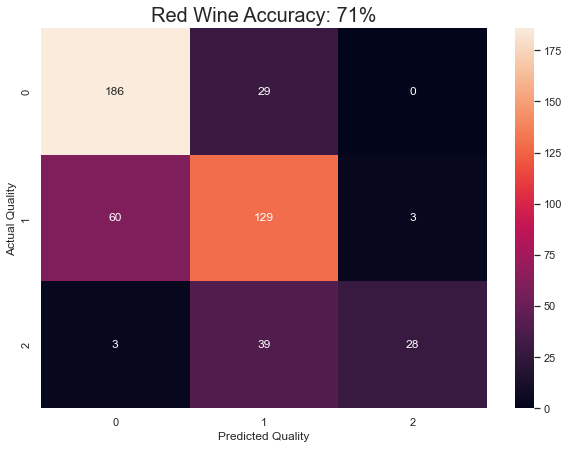

In [130]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(R_y_test, R_y_pred_rfc), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Red Wine Accuracy: {:d}%'.format(int(R_accuracy_rfc * 100)), size = 20)
plt.show()

### 8.1.3  Conclusion

Although the red wine accuracy is higher than the white accuracy (71% > 69%), looking at the confusion matrices, we can see that the red wine confusion matrix doesnt present a clear diagonal with higher values than the rest of the matrix (as it hapens in the third iteration with our DL model), it might be because there are 3 times less red wine data than there is of white whine.

As we explain in the Conclusion below (Point 9), if we want to use those models in a winery, the white wine model woudl be suitable, but the red wine model wouldn't be suitable (at least for the high quality predictions where it falls in the consufion matrix)

## 8.2  Predict the Type of Wine

There are several differences between the two types of wine, perhaps even more than between the three qualities. That is why we wondered whether a model would also be able to learn how to differentiate between white and red wine. This means changing the objective of the study completely, but the conclusions we have drawn throughout the project can also be applied to this approach to the problem. Therefore, let's check briefly the behaviour of a model if, instead of predicting the quality of the wine, we want to find out what kind of wine it is. We will use the same data preparation, modeling (random forest) & evaluation of the second iteration but changing the target. We have also removed some columns that negatively affect accuracy in this case.


In [131]:
wine_pc_type = wine_pc_out.copy(deep=True)
#wine_pc_type = wine_pc_type.drop(['chlorides'], axis=1) # Removed previously
wine_pc_type = wine_pc_type.drop(['citric acid'], axis=1)
wine_pc_type = wine_pc_type.drop(['fixed acidity'], axis=1)

x = wine_pc_type.drop(['type'], axis=1)
y = wine_pc_type['type']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=10)

In [132]:
rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
rfc.fit(X_train,y_train)

y_pred_rfc = rfc.predict(X_test)
accuracy_rfc = accuracy_score(y_test, y_pred_rfc)
print('Accuracy:', accuracy_rfc * 100, '%')

Accuracy: 99.8972250770812 %


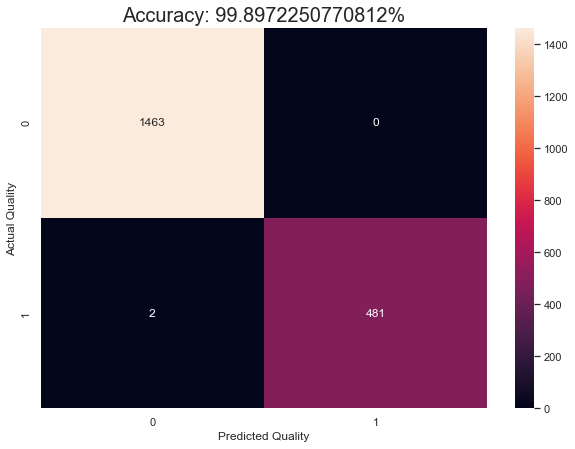

In [133]:
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test, y_pred_rfc), annot=True, fmt=".0f")
plt.xlabel('Predicted Quality')
plt.ylabel('Actual Quality')
plt.title('Accuracy: ' + str(accuracy_rfc * 100) + '%', size = 20)
plt.show()

Well, this is surprising! Predicting the type of wine reaches 99% accuracy, with practically no significant failures in the confusion matrix. We already thought we could achieve a good result because, during the development of the column study, we saw that there really is a big difference between the two wines, but we didn't think the prediction would be so perfect. 

We can conclude that, despite the fact that there are more white wines than red wines, predicting the type of wine is a piece of cake for the model. If we had known earlier, we might have approached the project in this way... 😂

# 9  Conclusion

The Ranfom Forest model, which is the best we have achieved, despite not having a well highlighted diagonal, it is present with some noise as we have been advised in class. A practical example of our model would be to apply it in the quality control of a winery, to analyze each batch of wines, and determine if it is:
  - A `low quality` wine, which most likely will have to be discarded.
  - Or a `very high quality` wine, which it would be advisable to separate from the rest of the wines to sell it at a more exclusive price.

  The model cannot ensure that a wine marked as `medium quality` (due to noise on the diagonal of the confusion matrix) really is, but it can help us detect that it is within an acceptable range of quality and that it is suitable for sale.

This project has allowed us to understand the whole process involved in working with a dataset and predicting its values. The column study has helped us to get to know the dataset in depth and to study its content. We have obtained conclusions that have evidently helped us to carry out the data preparation process. On the other hand, working with different models has made us realise how complicated it can be to achieve a good result and the factors that have to be taken into account.

In particular, despite the fact that this dataset is not very well distributed, good results have been obtained and the models work correctly. We have tried many combinations of data preparation and finally we have shown the most efficient and suitable changes for the dataset.

In summary, the level of knowledge of machine learning and deep learning has increased thanks to the demands of this practice and the work involved in carrying it out. Also, working in a team has allowed us to share the work among us, discuss the decisions made and reach conclusions by helping each other. In addition, the abundant documentation available and the generosity of the teacher have allowed a continuous evolution and have made the development of the practical possible. 

# 10  Wine Data Bibliography

* 4.2.2 [Fixed Acidity](https://waterhouse.ucdavis.edu/whats-in-wine/fixed-acidity)

* 4.2.2 [Fixed Acidity](https://home.binwise.com/blog/is-wine-acidic)

* 4.2.3 [Volatile Acidity](https://extension.psu.edu/volatile-acidity-in-wine#:~:text=In%20general%2C%20per%20the%20CFR,red%20and%20white%20wines%2C%20respectively.)


* 4.2.5 [Residual Sugar](https://daily.sevenfifty.com/understanding-the-role-of-sugar-in-wine/)

* 4.2.6 [Chlorides](https://www.awri.com.au/wp-content/uploads/2018/08/s1530.pdf)

* 4.2.6 [Chlorides](https://www.sciencedirect.com/science/article/abs/pii/S0308814696003408)

* 4.2.7 [Free Sulfur Dioxide](https://www.oiv.int/public/medias/7840/oiv-collective-expertise-document-so2-and-wine-a-review.pdf)

* 4.2.7 [Free Sulfur Dioxide](https://www.umpqua.edu/images/areas-of-study/career-technical/viticulture-enology/downloads/conferences/technical-symposia/2011-march-wine-flaws/2011-ts-burns-managing-so2.pdf)

* 4.2.7 [Free Sulfur Dioxide](https://grapesandwine.cals.cornell.edu/sites/grapesandwine.cals.cornell.edu/files/shared/documents/Research-Focus-2011-3.pdf)

* 4.2.10 [pH](https://www.aprenderdevino.es/ph-y-vino/)

* 4.2.12 [Alcohol](https://blog.matarromera.es/vino/por-que-tiene-alcohol-el-vino#:~:text=Como%20te%20hemos%20adelantado%20ya,la%20acci%C3%B3n%20de%20las%20levaduras.)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d2b0bc93-ab04-4417-a934-78b8b04aff09' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>